In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
from utils import performance, calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from data_generators import NoisyTargetGenerator
import matplotlib.pyplot as plt
from sound import Sound
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
base_shape_size = 8192
ws = 255
ol = 128
NORM_FACTOR = 128
input_shape = (128, 64, 1)

In [4]:
sound_base_train = Sound('/tf/Dados/Vozes/train/', '/tf/Dados/Ruido/train/', base_shape_size)
sound_base_val = Sound('/tf/Dados/Vozes/val/', '/tf/Dados/Ruido/val/', base_shape_size)

Loading Speech Files: 100%|██████████| 1635/1635 [00:02<00:00, 670.30it/s]


In [5]:
data_generator_train = NoisyTargetGenerator(sound_base_train.clean_sounds, sound_base_train.noise_sounds)
data_generator_val = NoisyTargetGenerator(sound_base_val.clean_sounds, sound_base_val.noise_sounds, add_white=False)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, filter_size, batch_norm=False, dropout=0):
        super(DoubleConv, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=1),
            nn.ReLU(inplace=True)
        ]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.extend([
            nn.Conv2d(out_channels, out_channels, kernel_size=filter_size, padding=1),
            nn.ReLU(inplace=True)
        ])
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        self.double_conv = nn.Sequential(*layers)
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity()
        )
        
    def forward(self, x):
        return self.double_conv(x) + self.shortcut(x)

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels):
        super(AttentionBlock, self).__init__()
        self.theta_x = nn.Conv2d(in_channels, inter_channels, kernel_size=2, stride=2, padding=0)
        self.phi_g = nn.Conv2d(gating_channels, inter_channels, kernel_size=1, padding=0)
        self.upsample_g = nn.ConvTranspose2d(inter_channels, inter_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1, padding=0)
        self.upsample_psi = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.result = nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0)
        self.bn = nn.BatchNorm2d(in_channels)
        
    def forward(self, x, g):
        theta_x = self.theta_x(x)
        phi_g = self.phi_g(g)
        
        # Ajustar a dimensão de phi_g para coincidir com theta_x
        if theta_x.shape != phi_g.shape:
            phi_g = F.interpolate(phi_g, size=theta_x.shape[2:], mode='bilinear', align_corners=True)
        
        concat_xg = F.relu(theta_x + phi_g)
        psi = torch.sigmoid(self.psi(concat_xg))
        upsample_psi = self.upsample_psi(psi)
        y = upsample_psi * x
        result = self.result(y)
        return self.bn(result)

In [9]:
class AttentionResUNet(nn.Module):
    def __init__(self, input_channels=2, filter_num=32, filter_size=3, dropout_rate=0.1, batch_norm=True):
        super(AttentionResUNet, self).__init__()
        self.filter_num = filter_num
        self.filter_size = filter_size
        
        self.down1 = DoubleConv(input_channels, filter_num, filter_size, batch_norm, dropout_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down2 = DoubleConv(filter_num, filter_num*2, filter_size, batch_norm, dropout_rate)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down3 = DoubleConv(filter_num*2, filter_num*4, filter_size, batch_norm, dropout_rate)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down4 = DoubleConv(filter_num*4, filter_num*8, filter_size, batch_norm, dropout_rate)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down5 = DoubleConv(filter_num*8, filter_num*16, filter_size, batch_norm, dropout_rate)
        
        self.att4 = AttentionBlock(filter_num*8, filter_num*16, filter_num*8)
        self.up4 = nn.ConvTranspose2d(filter_num*16, filter_num*8, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(filter_num*16, filter_num*8, filter_size, batch_norm, dropout_rate)
        
        self.att3 = AttentionBlock(filter_num*4, filter_num*8, filter_num*4)
        self.up3 = nn.ConvTranspose2d(filter_num*8, filter_num*4, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(filter_num*8, filter_num*4, filter_size, batch_norm, dropout_rate)
        
        self.att2 = AttentionBlock(filter_num*2, filter_num*4, filter_num*2)
        self.up2 = nn.ConvTranspose2d(filter_num*4, filter_num*2, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(filter_num*4, filter_num*2, filter_size, batch_norm, dropout_rate)
        
        self.att1 = AttentionBlock(filter_num, filter_num*2, filter_num)
        self.up1 = nn.ConvTranspose2d(filter_num*2, filter_num, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(filter_num*2, filter_num, filter_size, batch_norm, dropout_rate)
        
        self.final_conv = nn.Conv2d(filter_num, input_channels, kernel_size=1)
        self.final_activation = nn.ReLU()
        
    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)
        down3 = self.down3(pool2)
        pool3 = self.pool3(down3)
        down4 = self.down4(pool3)
        pool4 = self.pool4(down4)
        down5 = self.down5(pool4)
        
        att4 = self.att4(down4, down5)
        up4 = self.up4(down5)
        up4 = torch.cat([up4, att4], dim=1)
        up_conv4 = self.up_conv4(up4)
        
        att3 = self.att3(down3, up_conv4)
        up3 = self.up3(up_conv4)
        up3 = torch.cat([up3, att3], dim=1)
        up_conv3 = self.up_conv3(up3)
        
        att2 = self.att2(down2, up_conv3)
        up2 = self.up2(up_conv3)
        up2 = torch.cat([up2, att2], dim=1)
        up_conv2 = self.up_conv2(up2)
        
        att1 = self.att1(down1, up_conv2)
        up1 = self.up1(up_conv2)
        up1 = torch.cat([up1, att1], dim=1)
        up_conv1 = self.up_conv1(up1)
        
        final = self.final_conv(up_conv1)
        output = self.final_activation(final)
        return output

In [15]:
batch_size = 64
lr = 5e-5
epochs = 50
DEVICE = torch.device("cuda")
in_channels = 1
print_step = 100

In [11]:
# Exemplo de uso
model = AttentionResUNet(input_channels=in_channels, filter_num=32, filter_size=3, dropout_rate=0.1, batch_norm=True).to(DEVICE)

In [16]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

In [17]:
def generate_images(model, test_input, tar):
    model.eval()  # Defina o modelo para modo de avaliação
    with torch.no_grad():
        prediction = model(test_input)[0].cpu().numpy()  # Supondo que a predição é o primeiro elemento do tuple

    print(prediction.shape)
    test_input = test_input.cpu().numpy()
    tar = tar.cpu().numpy()

    plt.figure(figsize=(22, 7))
    display_list = [test_input[0], tar[0], prediction]
    title = ['Log Power Spectrum - Som ruidoso', 'Log Power Spectrum - Som original', 'Log Power Spectrum - Som filtrado']
    print(display_list[-1].shape)
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(10 * np.log10((display_list[i][0, :, :])**2), aspect='auto', cmap='inferno')
        plt.colorbar(format='%+2.0f dB')
        plt.axis('off')

    plt.show()
    model.train()  # Retorne o modelo ao modo de treinamento

Start training Attention Res U-Net...
Running Epoch: 0


Epoch 1:   0%|          | 0/438 [00:00<?, ?batch/s]

(1, 128, 64)
(1, 128, 64)


/tmp/ipykernel_4794/1960136733.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10 * np.log10((display_list[i][0, :, :])**2), aspect='auto', cmap='inferno')


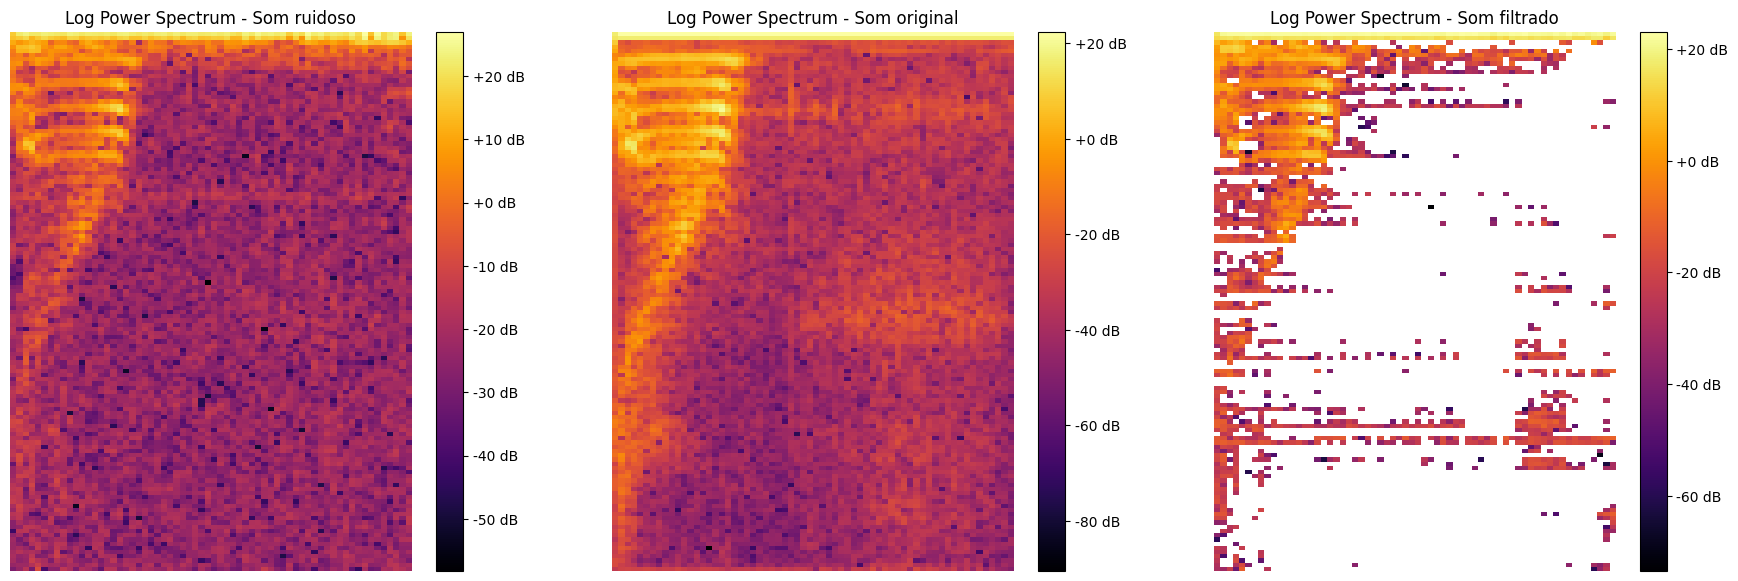

Epoch 1:  23%|██▎       | 100/438 [04:51<16:24,  2.91s/batch, loss=0.0435]

(1, 128, 64)
(1, 128, 64)


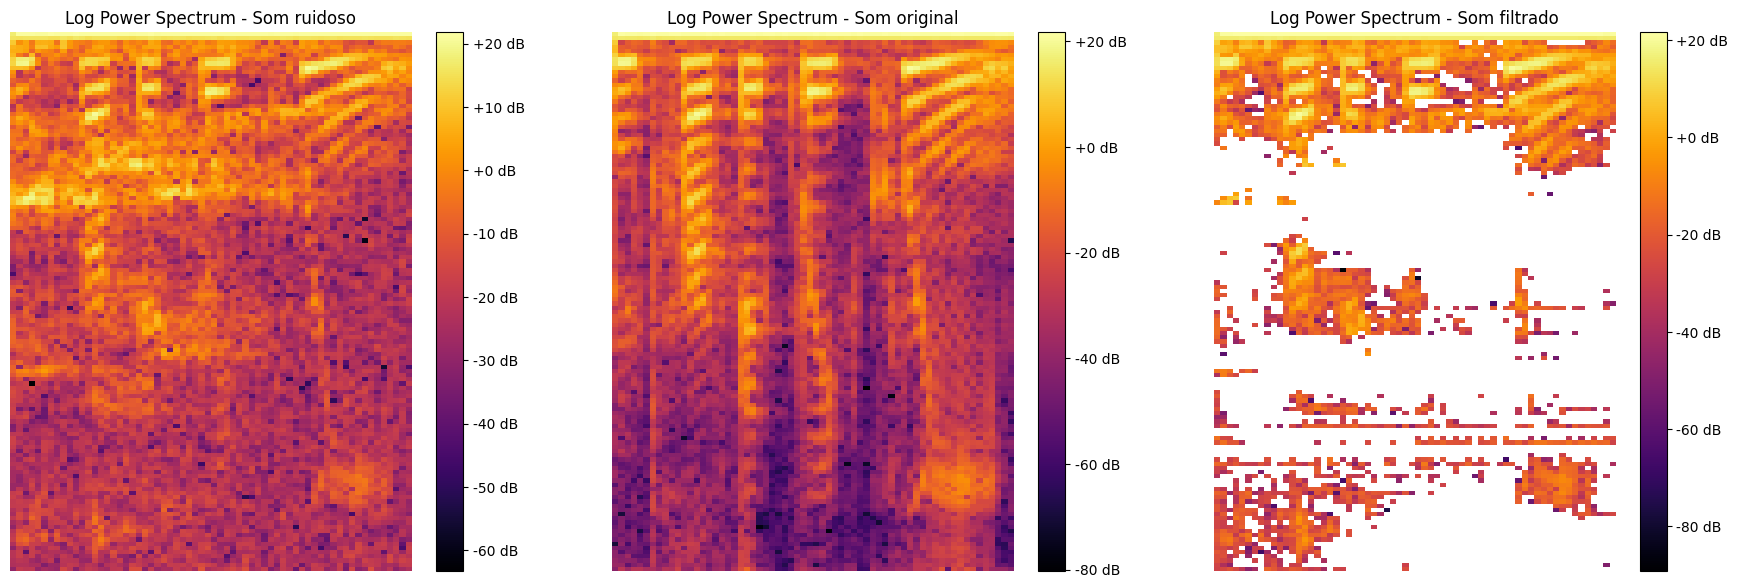

Epoch 1:  46%|████▌     | 200/438 [09:43<11:34,  2.92s/batch, loss=0.0625]

(1, 128, 64)
(1, 128, 64)


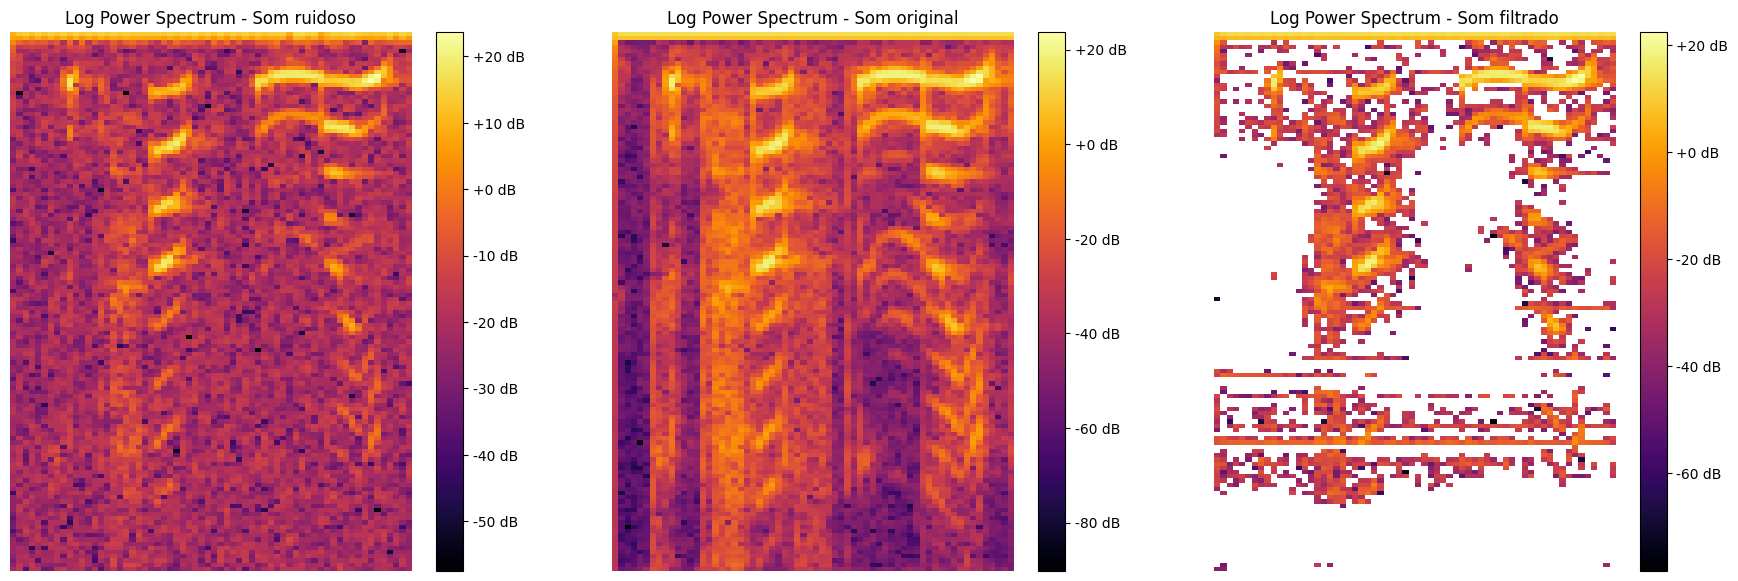

Epoch 1:  68%|██████▊   | 300/438 [14:35<06:42,  2.91s/batch, loss=0.0386]

(1, 128, 64)
(1, 128, 64)


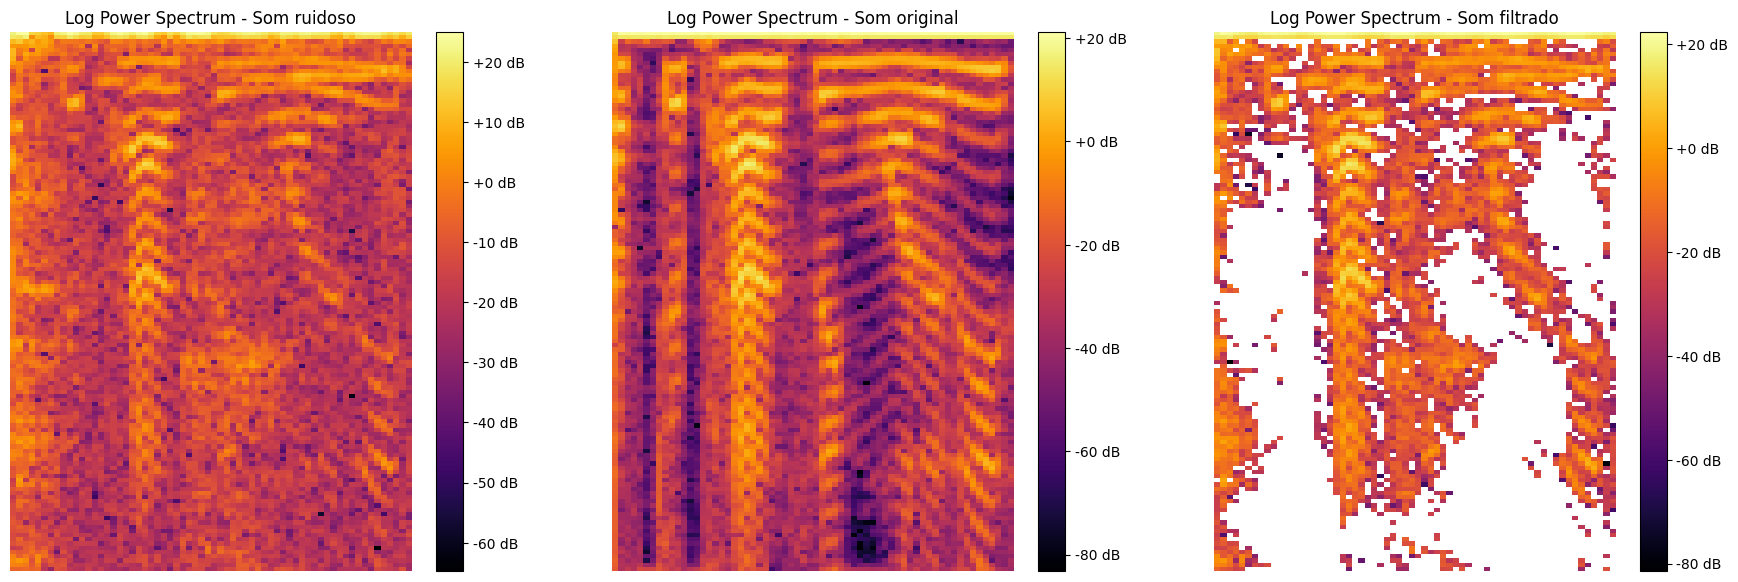

Epoch 1:  91%|█████████▏| 400/438 [19:27<01:50,  2.92s/batch, loss=0.0342]

(1, 128, 64)
(1, 128, 64)


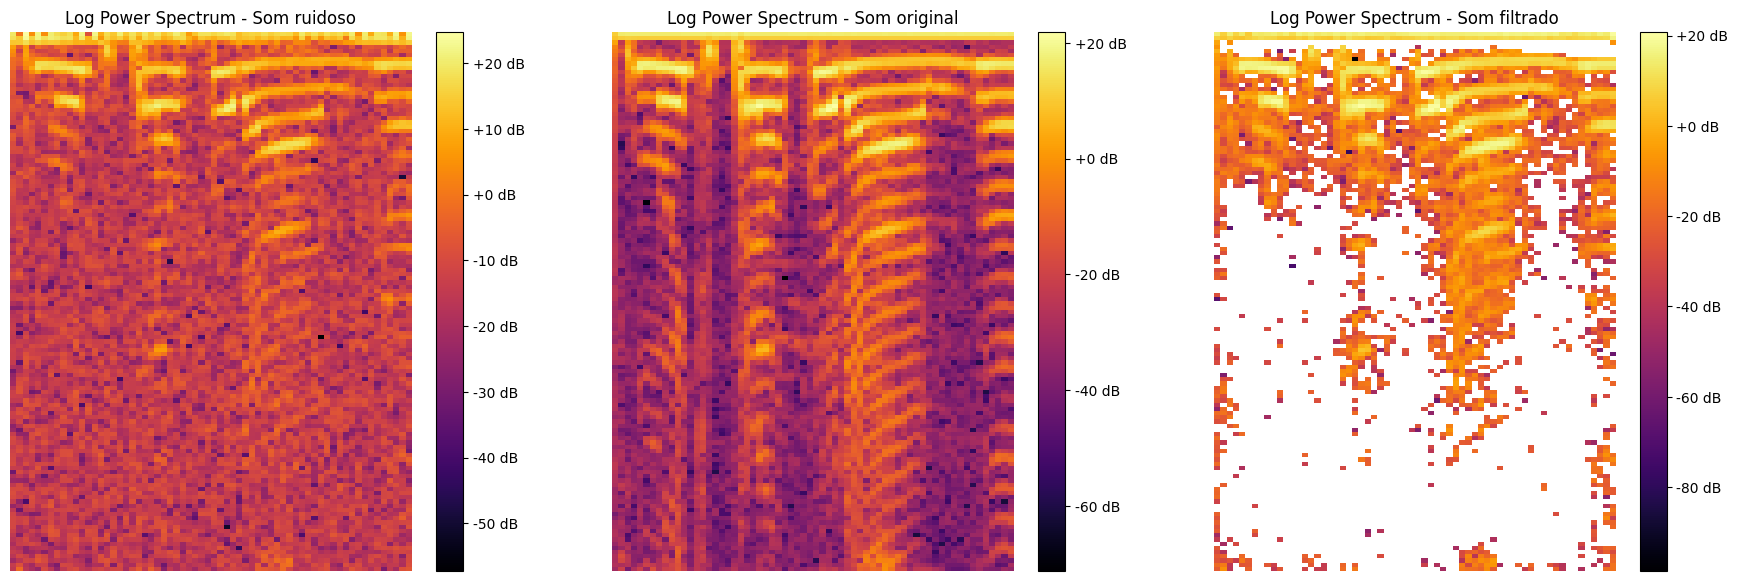

Epoch 1: 100%|█████████▉| 437/438 [21:18<00:02,  2.93s/batch, loss=0.07]  


Running Epoch: 1


Epoch 2:   0%|          | 0/438 [00:00<?, ?batch/s]

(1, 128, 64)
(1, 128, 64)


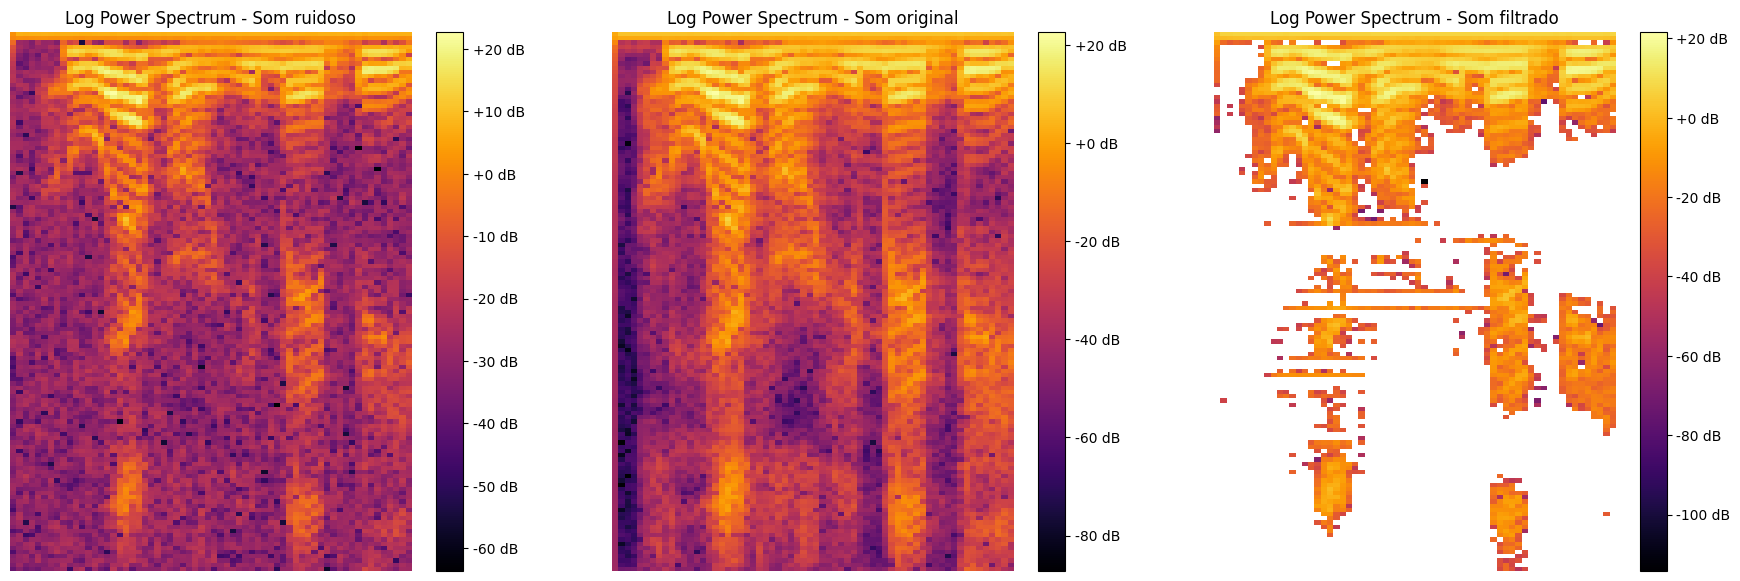

Epoch 2:  23%|██▎       | 100/438 [04:51<16:25,  2.92s/batch, loss=0.0459]

(1, 128, 64)
(1, 128, 64)


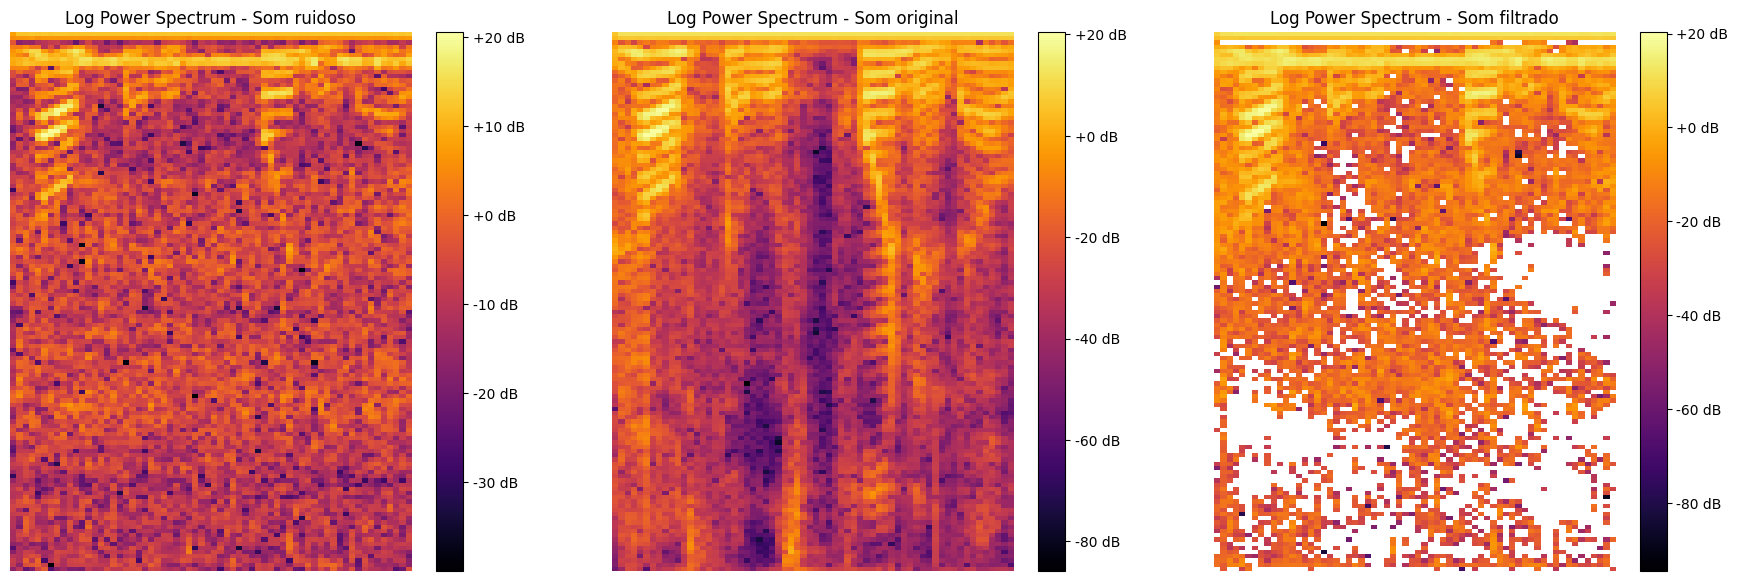

Epoch 2:  46%|████▌     | 200/438 [09:43<11:32,  2.91s/batch, loss=0.0366]

(1, 128, 64)
(1, 128, 64)


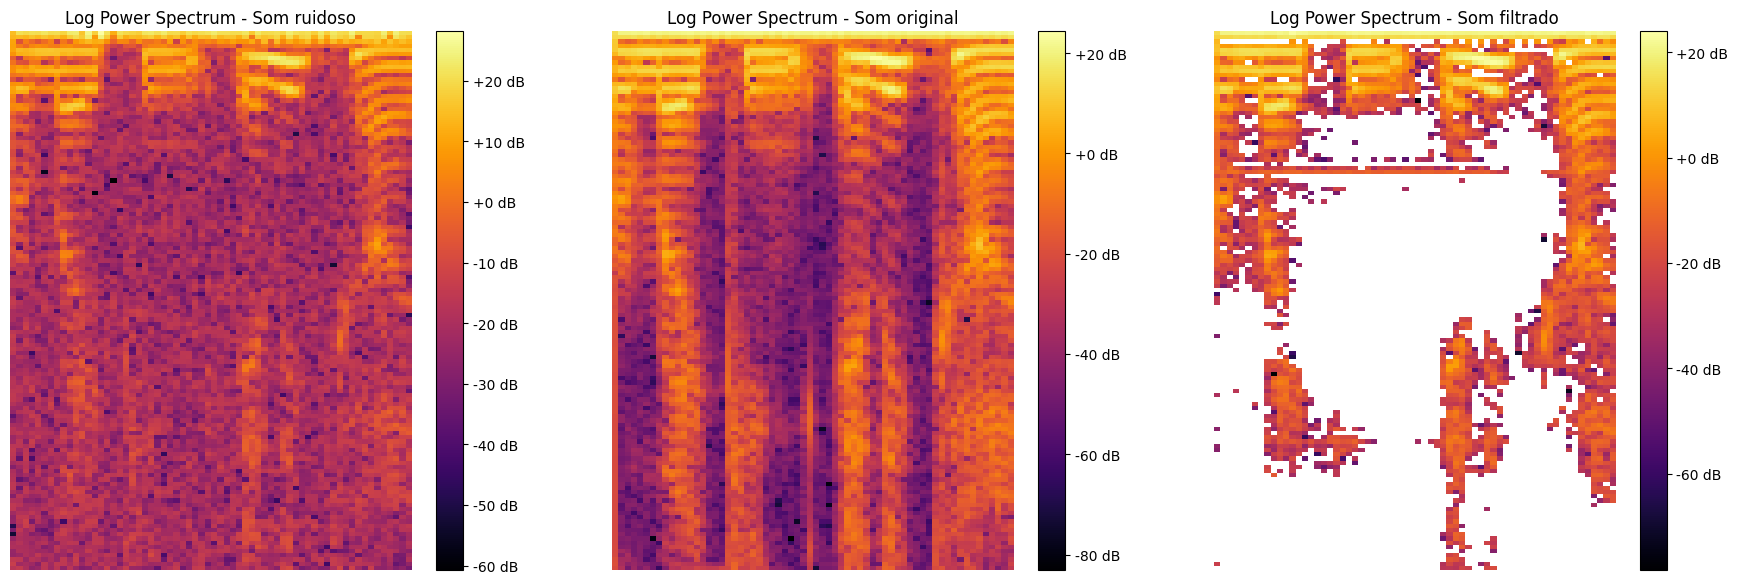

Epoch 2:  68%|██████▊   | 300/438 [14:35<06:42,  2.92s/batch, loss=0.0516]

(1, 128, 64)
(1, 128, 64)


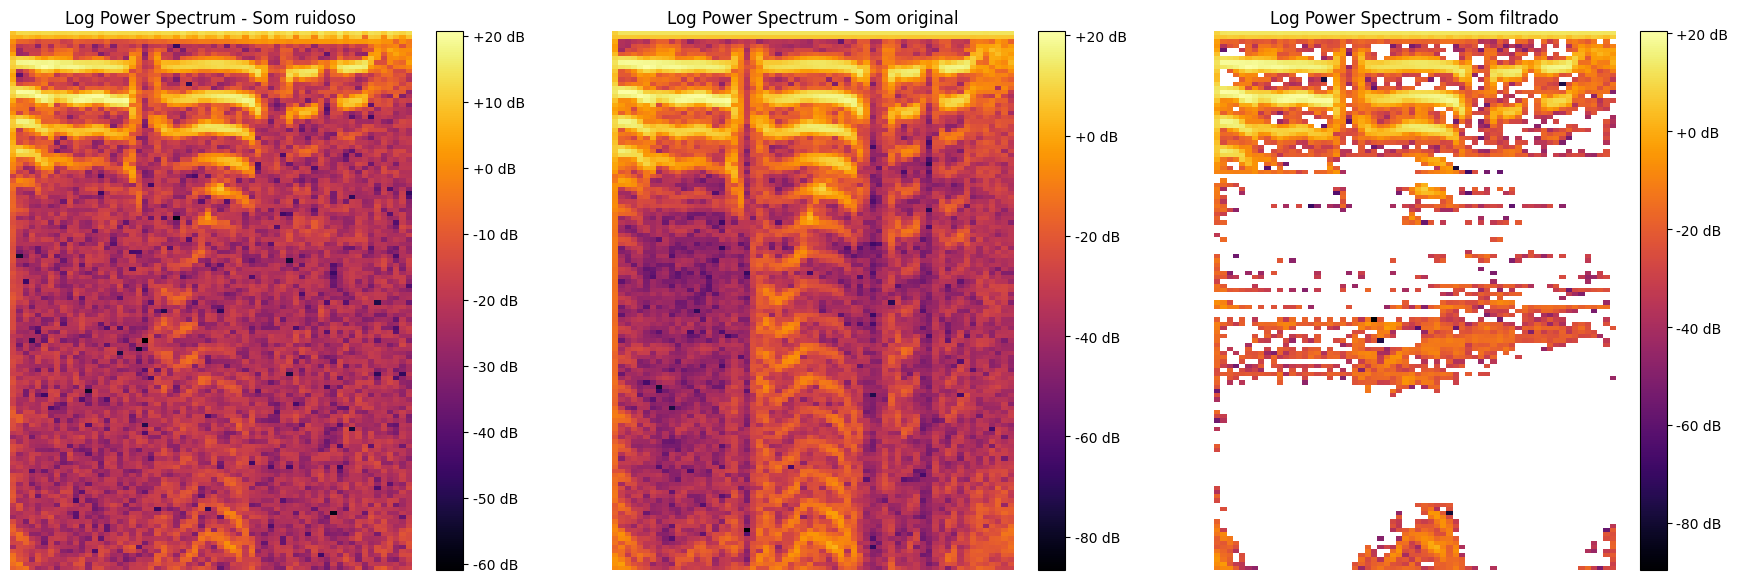

Epoch 2:  91%|█████████▏| 400/438 [19:27<01:50,  2.91s/batch, loss=0.0551]

(1, 128, 64)
(1, 128, 64)


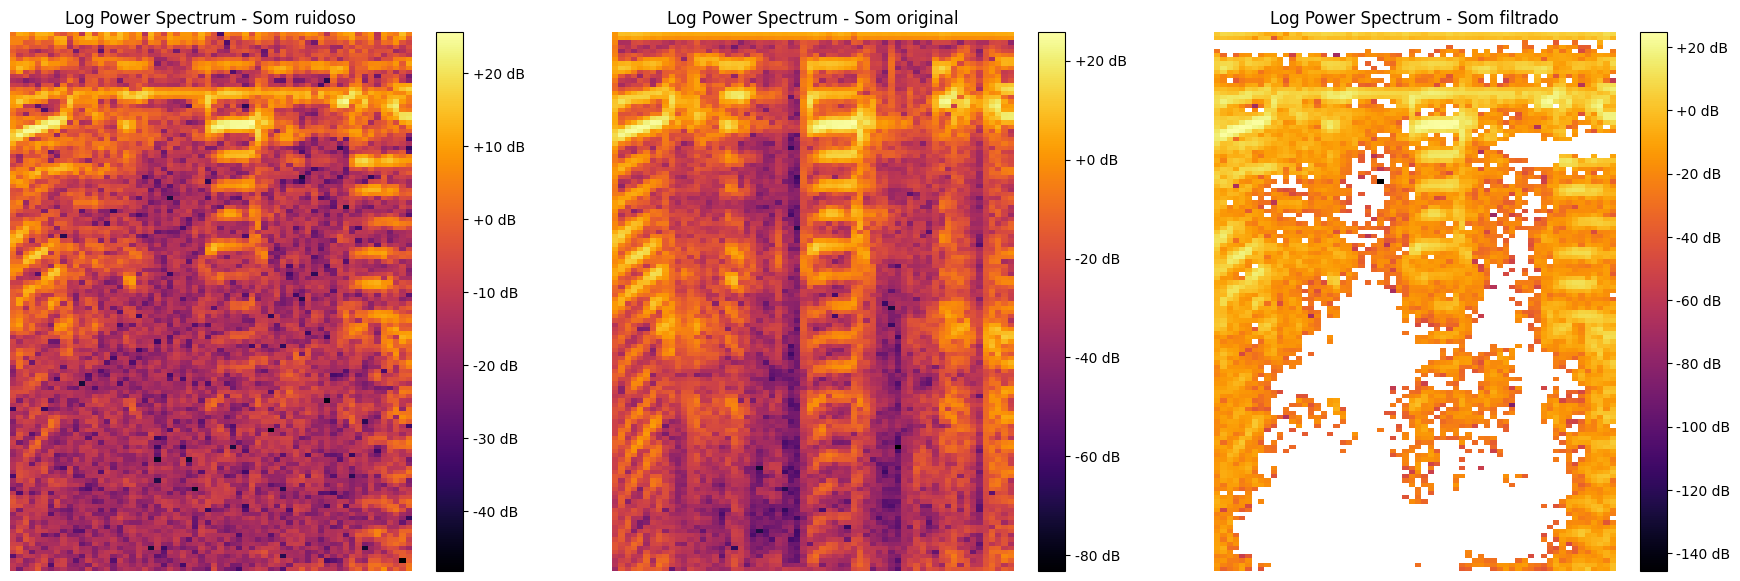

Epoch 2: 100%|█████████▉| 437/438 [21:19<00:02,  2.93s/batch, loss=0.0275]


Running Epoch: 2


Epoch 3:   0%|          | 0/438 [00:00<?, ?batch/s]

(1, 128, 64)
(1, 128, 64)


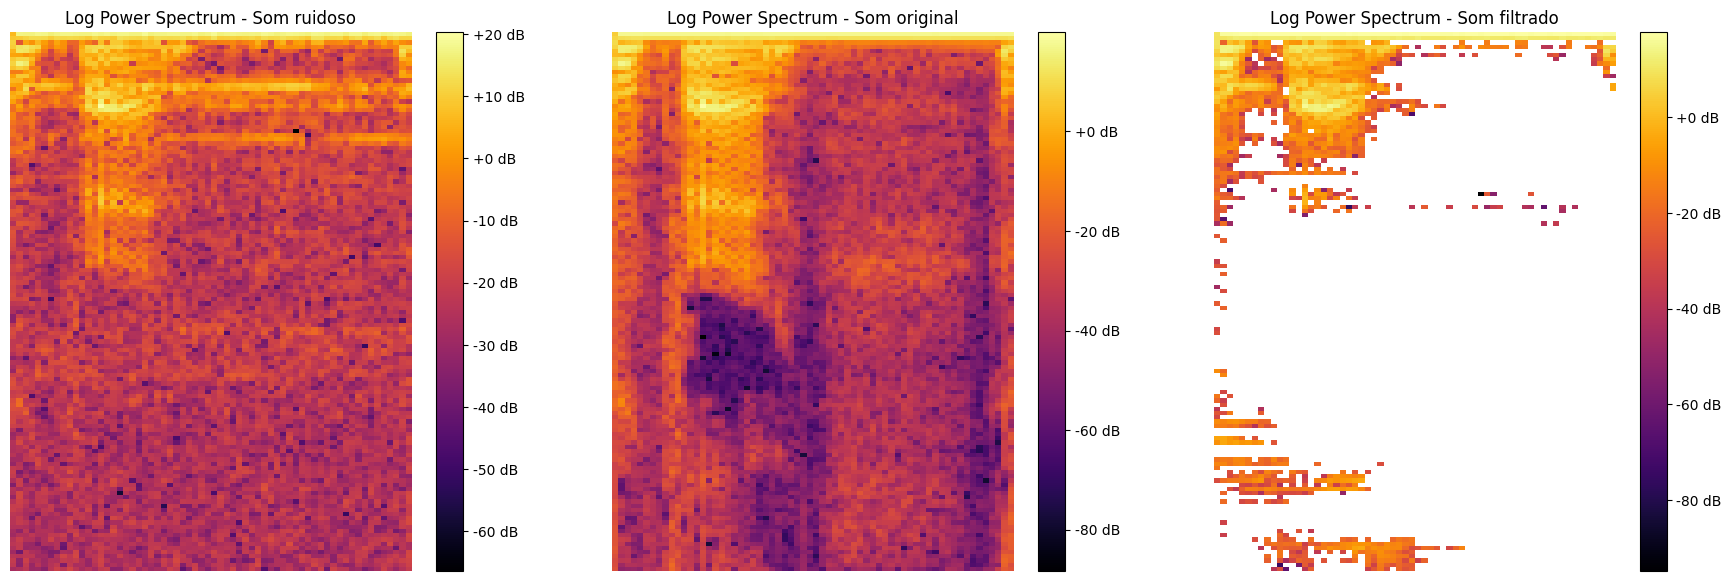

Epoch 3:  23%|██▎       | 100/438 [04:52<16:25,  2.92s/batch, loss=0.0403]

(1, 128, 64)
(1, 128, 64)


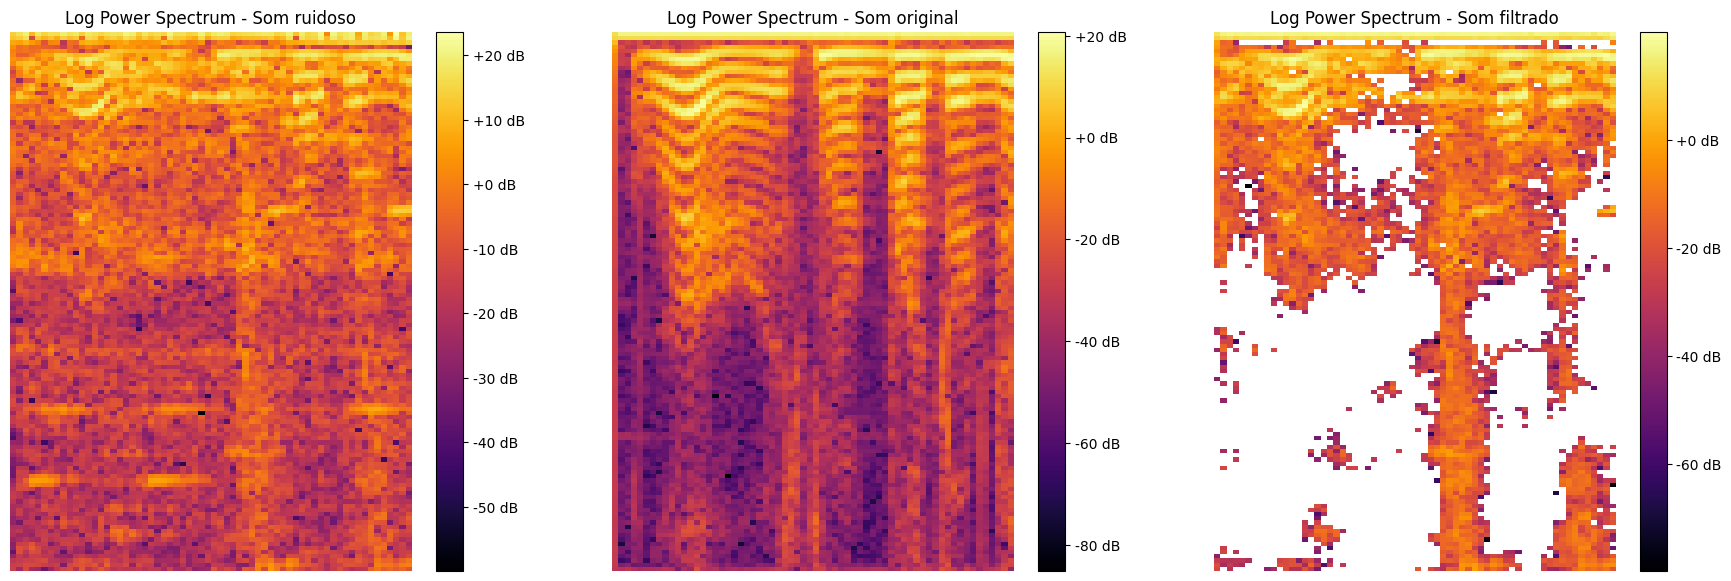

Epoch 3:  46%|████▌     | 200/438 [09:44<11:34,  2.92s/batch, loss=0.051] 

(1, 128, 64)
(1, 128, 64)


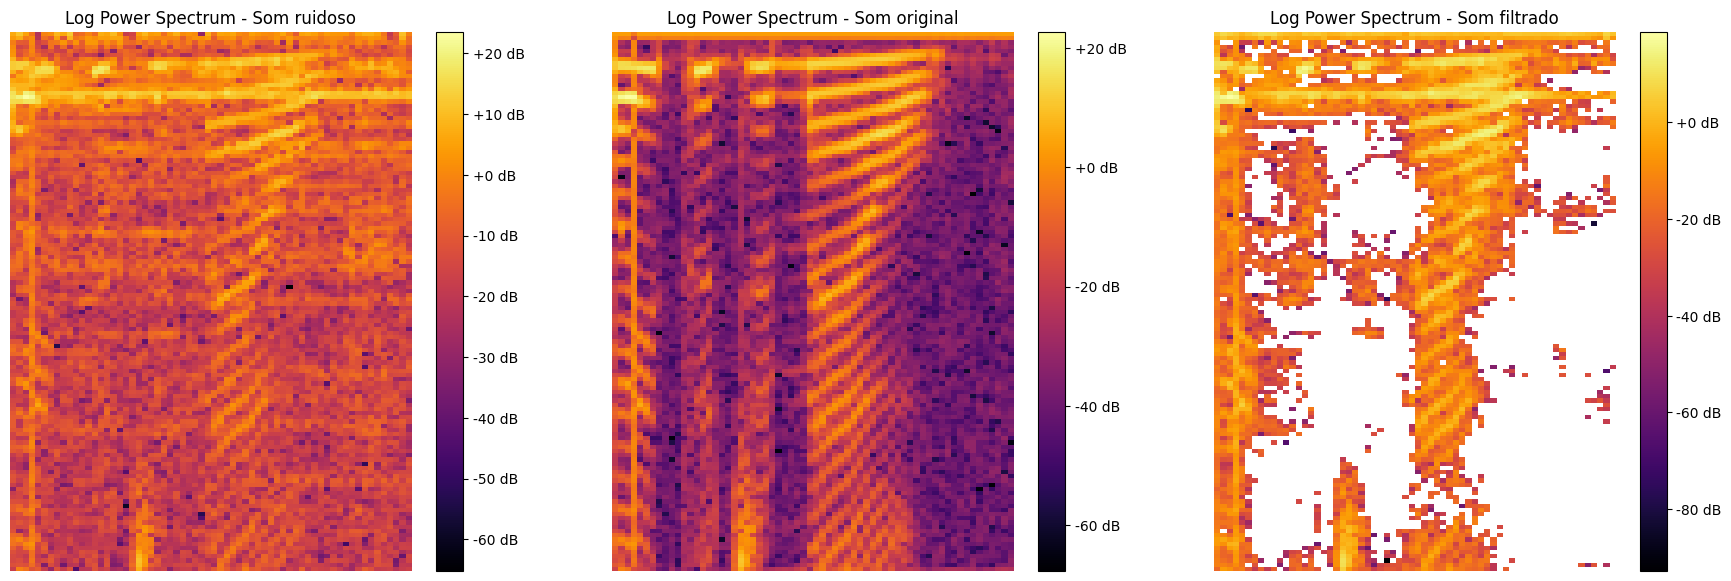

Epoch 3:  68%|██████▊   | 300/438 [14:34<06:35,  2.86s/batch, loss=0.0258]

(1, 128, 64)
(1, 128, 64)


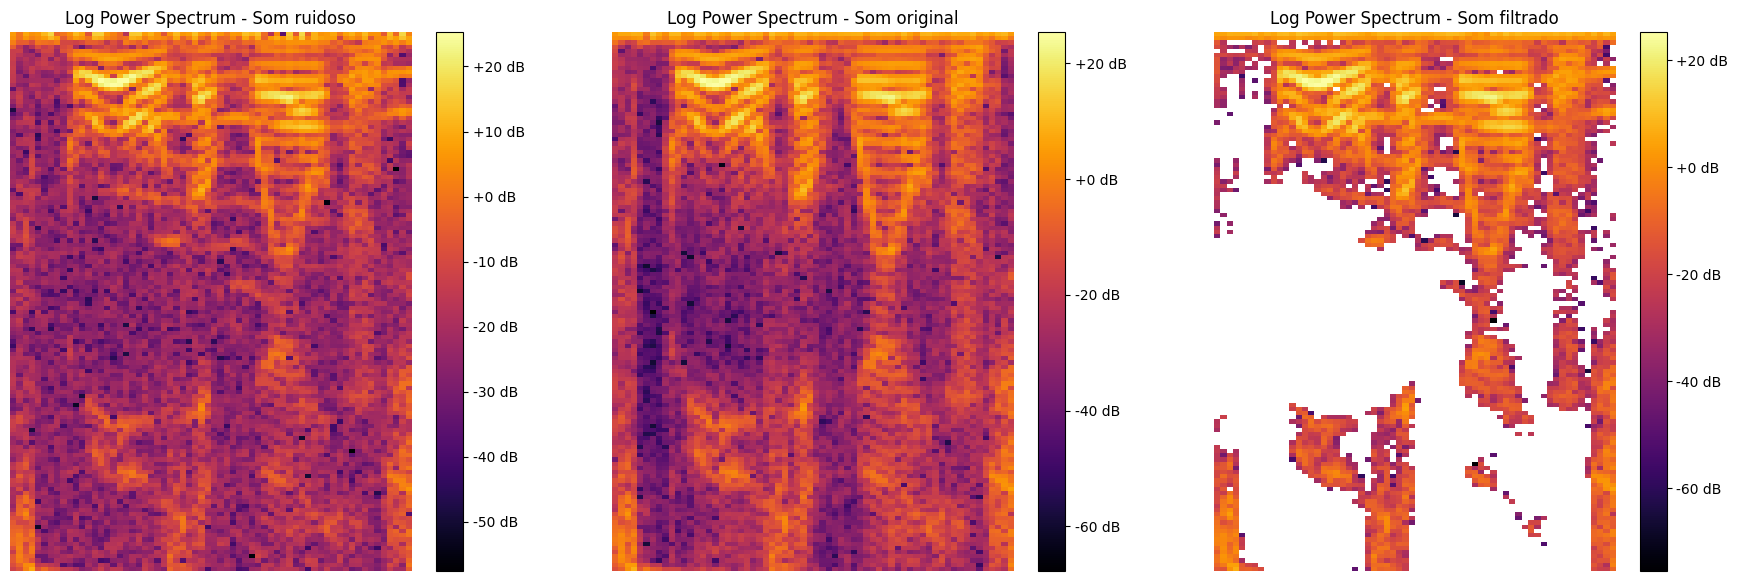

Epoch 3:  91%|█████████▏| 400/438 [19:20<01:48,  2.87s/batch, loss=0.0397]

(1, 128, 64)
(1, 128, 64)


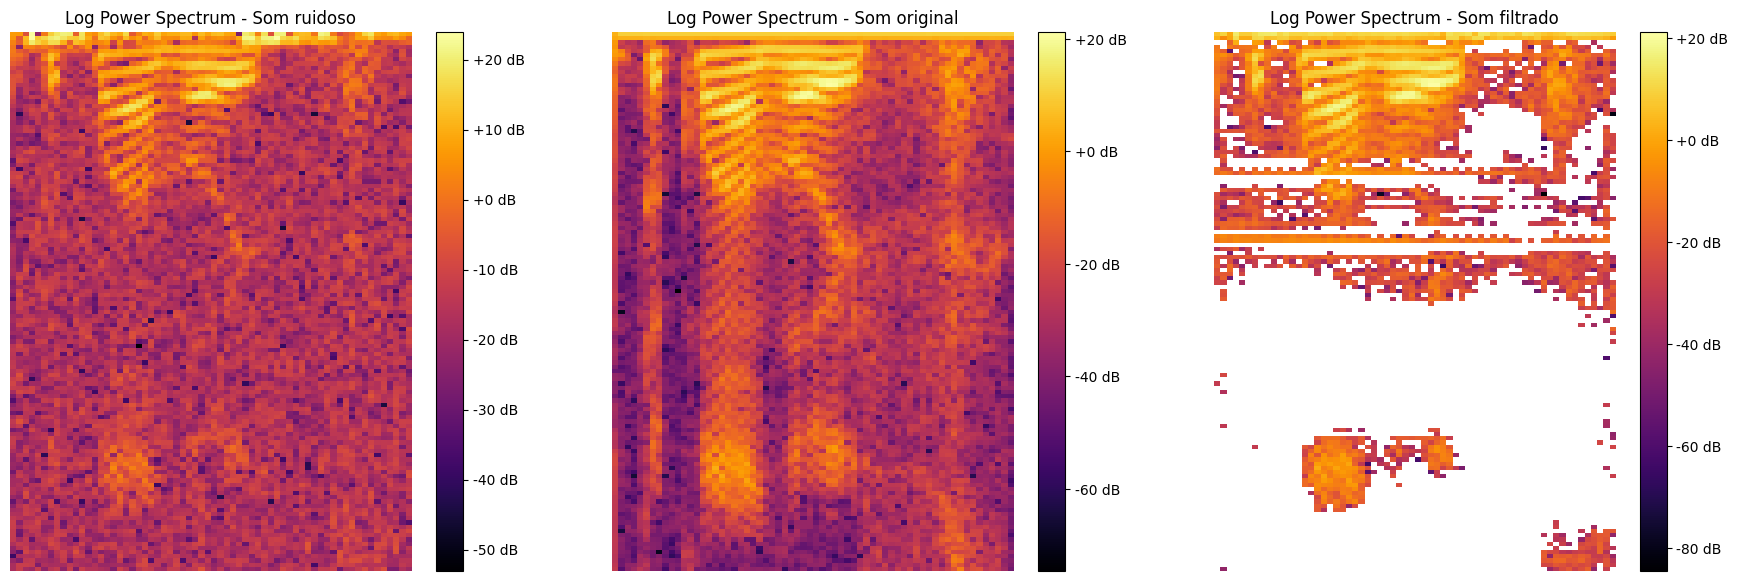

Epoch 3: 100%|█████████▉| 437/438 [21:10<00:02,  2.91s/batch, loss=0.0334]


Running Epoch: 3


Epoch 4:   0%|          | 0/438 [00:00<?, ?batch/s]

(1, 128, 64)
(1, 128, 64)


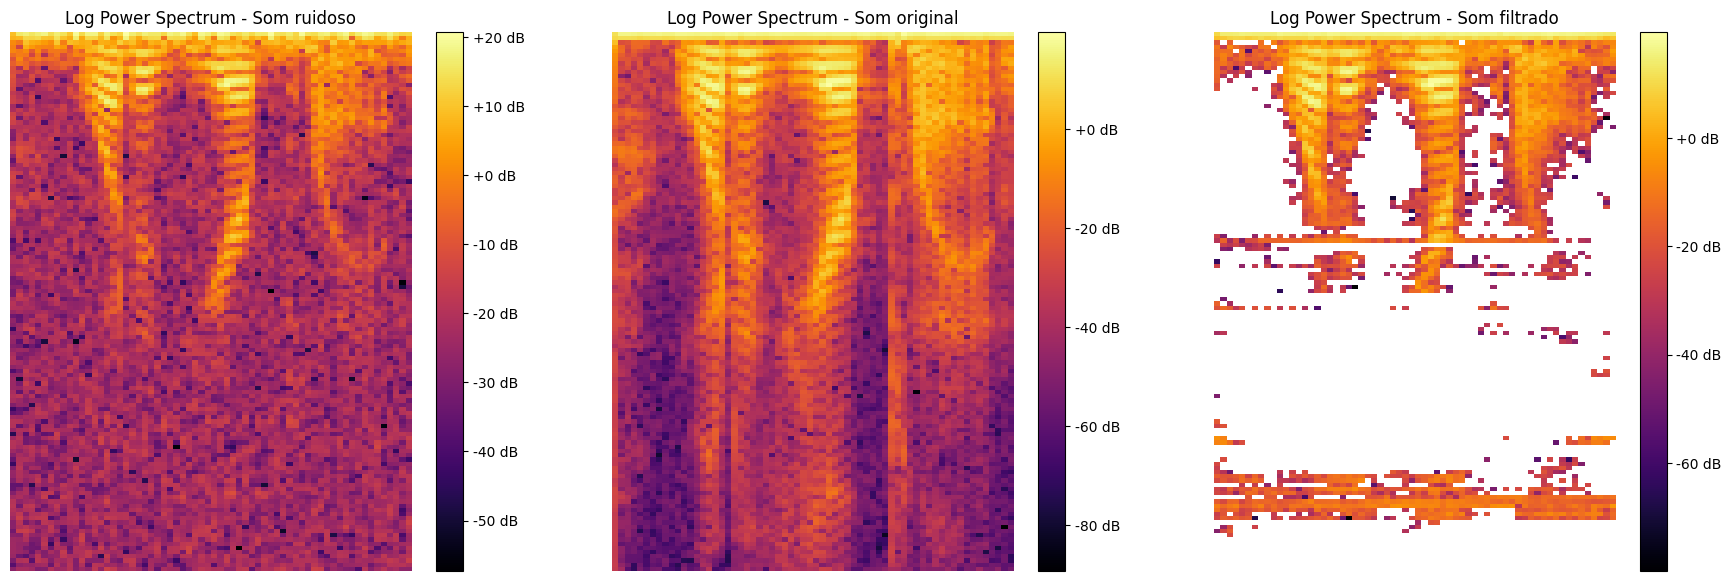

Epoch 4:  23%|██▎       | 100/438 [04:46<16:09,  2.87s/batch, loss=0.0383]

(1, 128, 64)
(1, 128, 64)


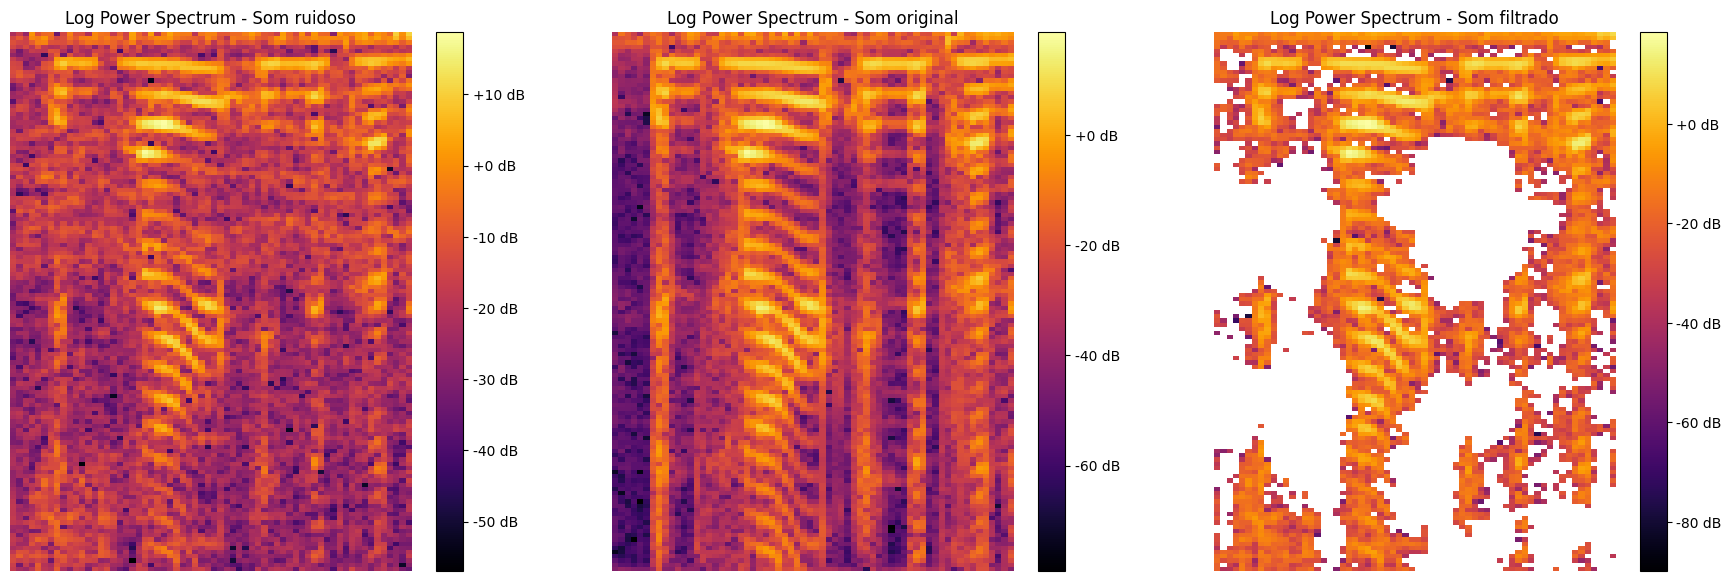

Epoch 4:  46%|████▌     | 200/438 [09:33<11:21,  2.86s/batch, loss=0.0302]

(1, 128, 64)
(1, 128, 64)


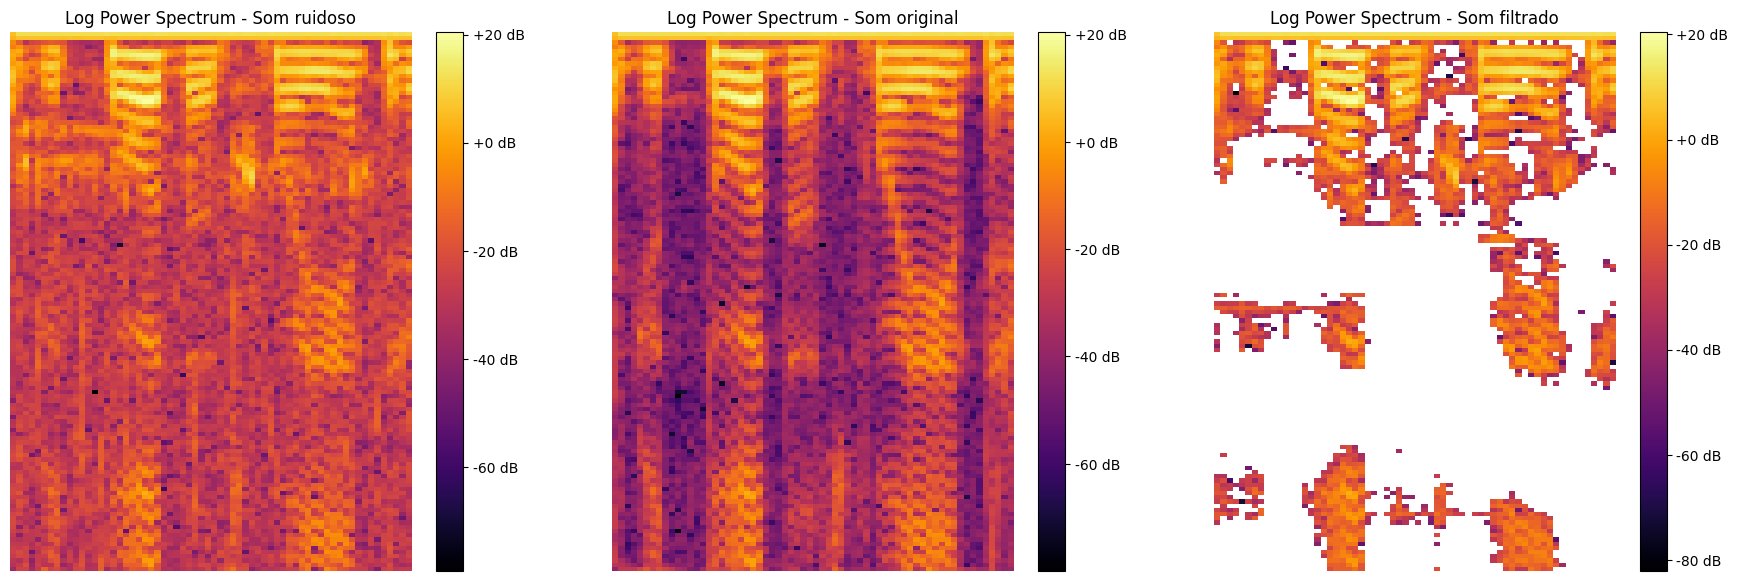

Epoch 4:  68%|██████▊   | 300/438 [14:20<06:35,  2.87s/batch, loss=0.0338]

(1, 128, 64)
(1, 128, 64)


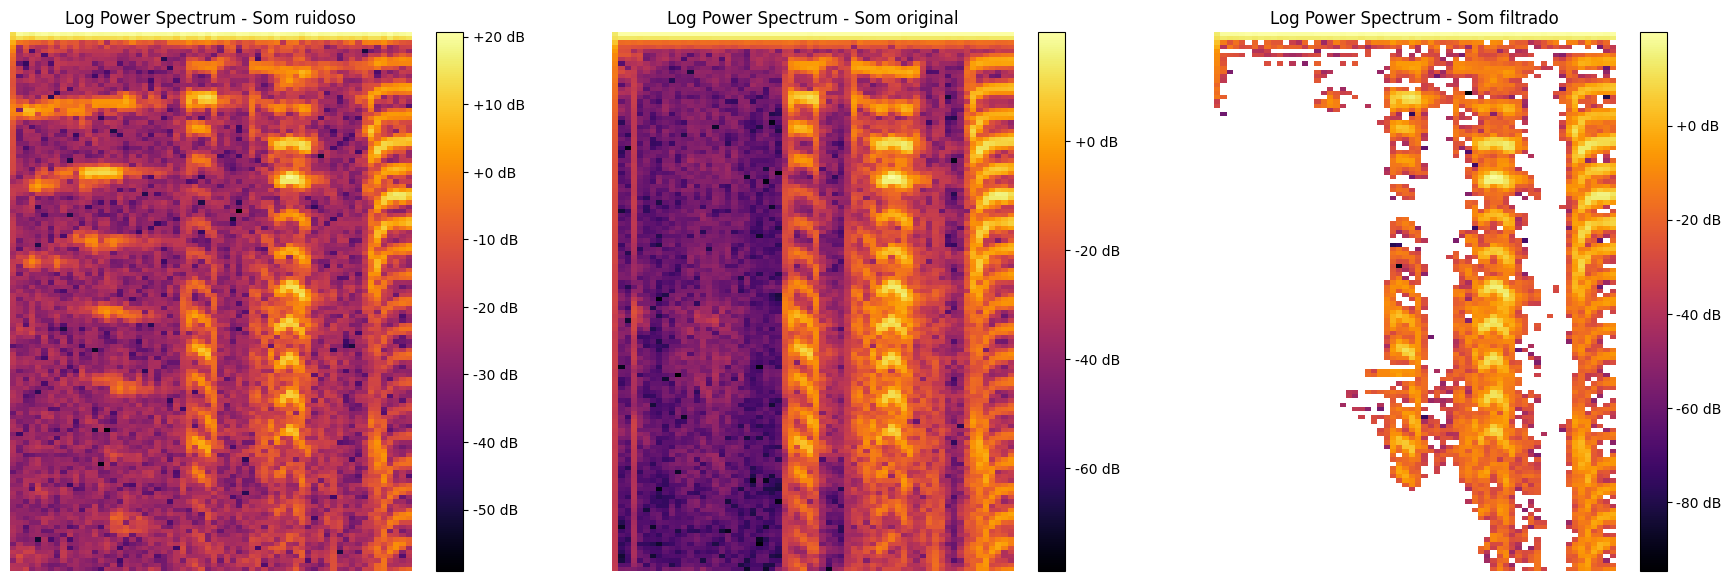

Epoch 4:  91%|█████████▏| 400/438 [19:07<01:48,  2.87s/batch, loss=0.0409]

(1, 128, 64)
(1, 128, 64)


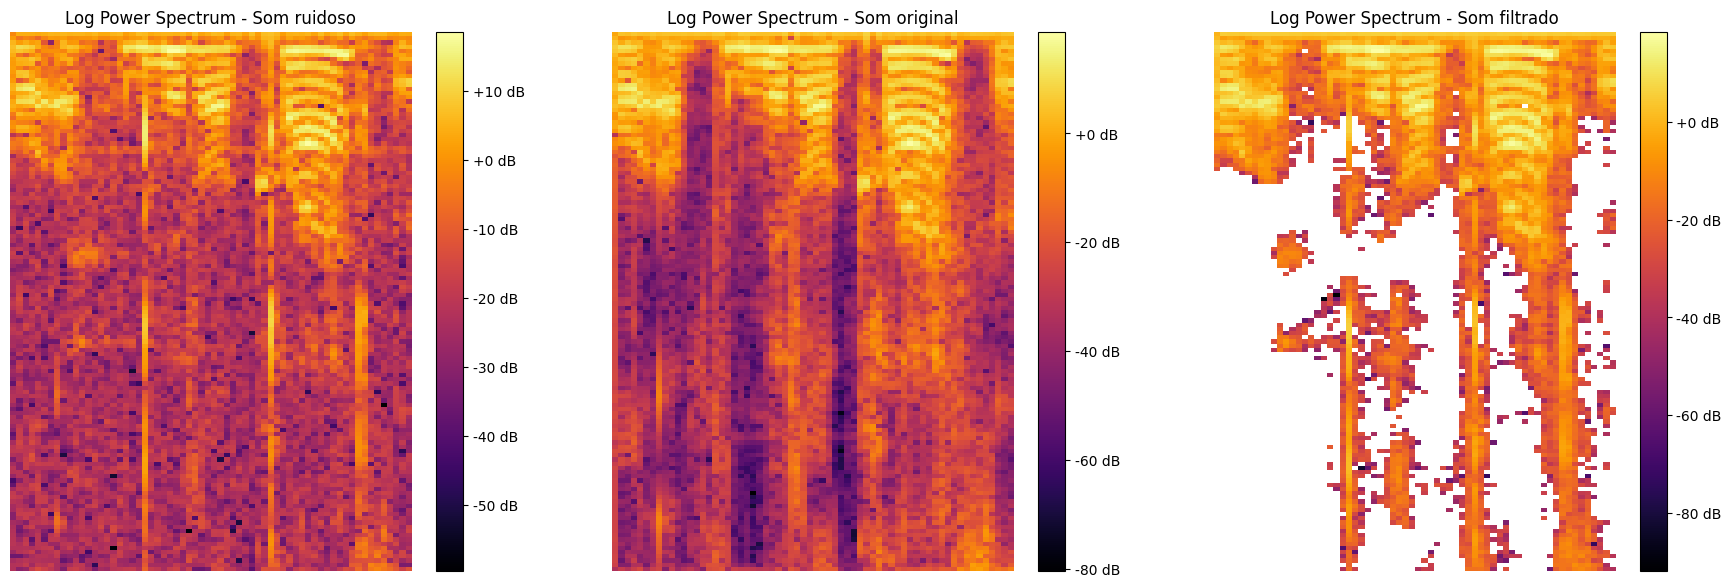

Epoch 4: 100%|█████████▉| 437/438 [20:56<00:02,  2.88s/batch, loss=0.0335]


Running Epoch: 4


Epoch 5:   0%|          | 0/438 [00:00<?, ?batch/s]

(1, 128, 64)
(1, 128, 64)


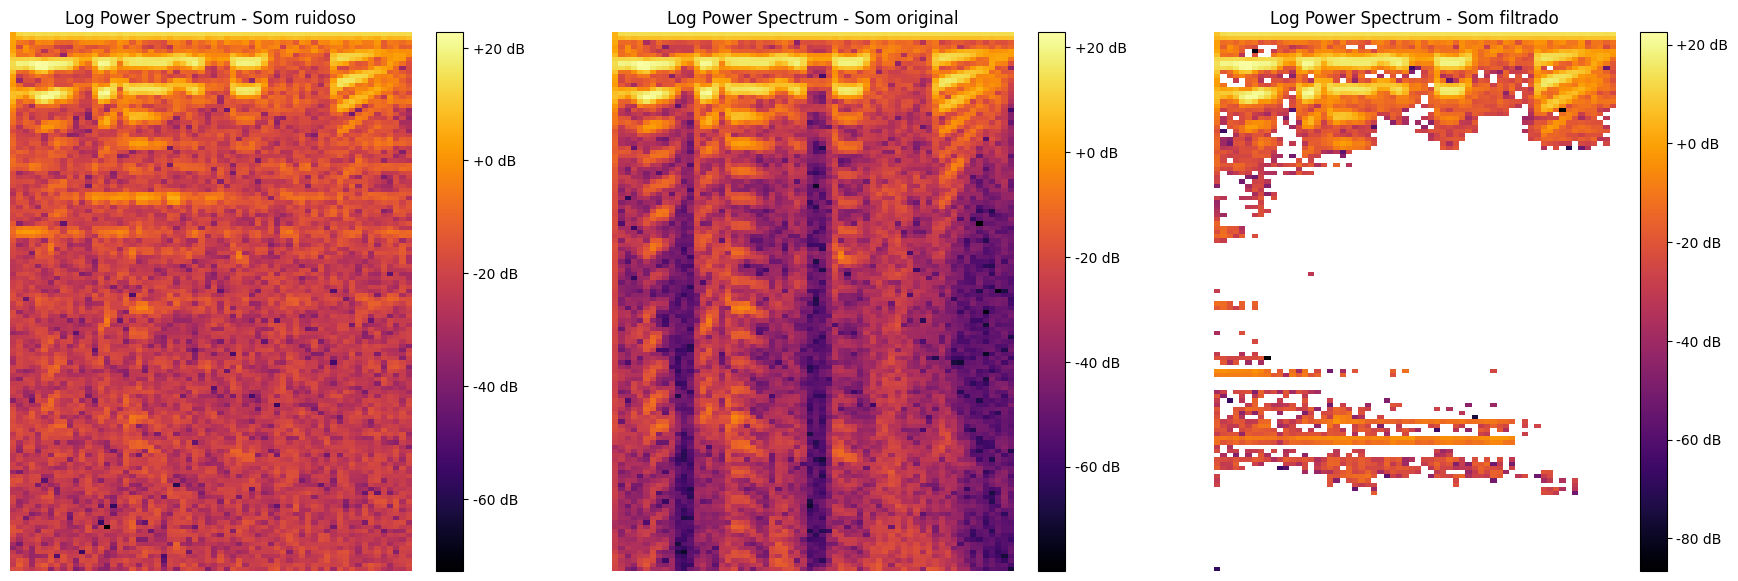

Epoch 5:  23%|██▎       | 100/438 [04:46<16:08,  2.86s/batch, loss=0.0254]

(1, 128, 64)
(1, 128, 64)


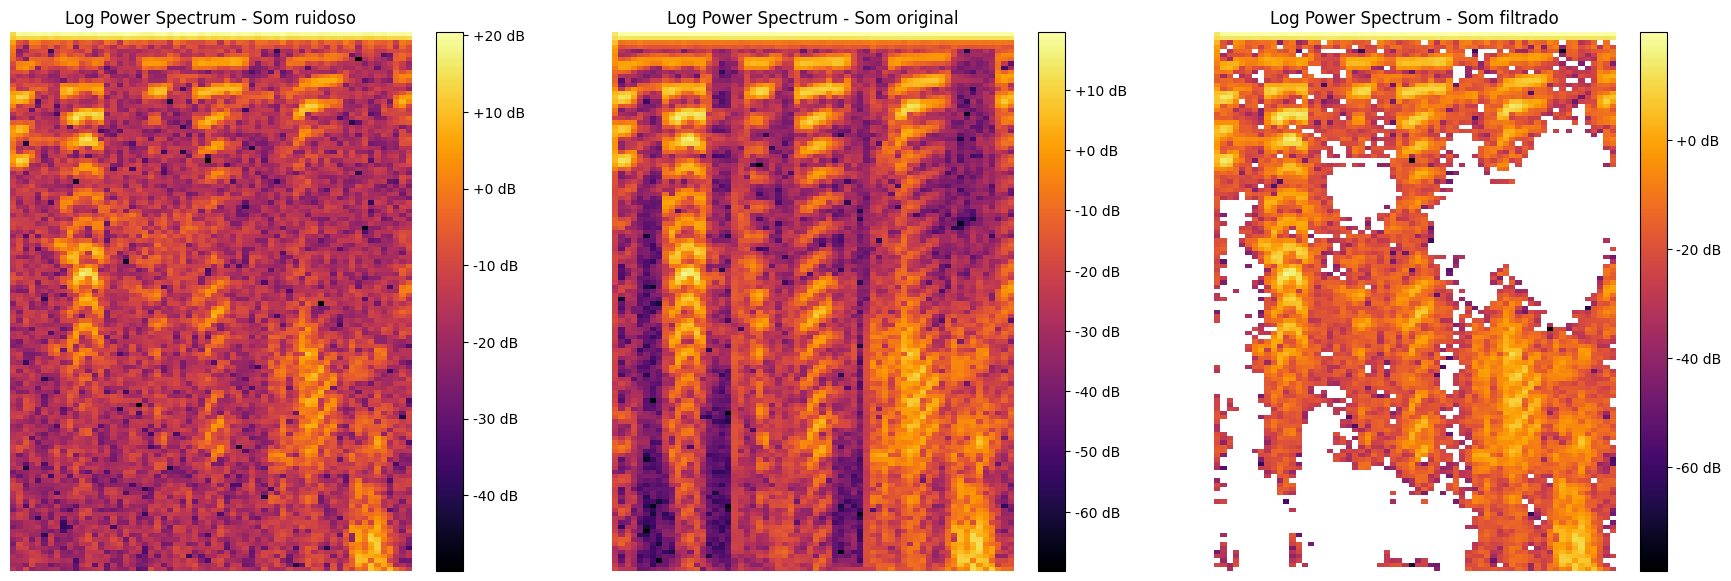

Epoch 5:  46%|████▌     | 200/438 [09:33<11:21,  2.87s/batch, loss=0.0356]

(1, 128, 64)
(1, 128, 64)


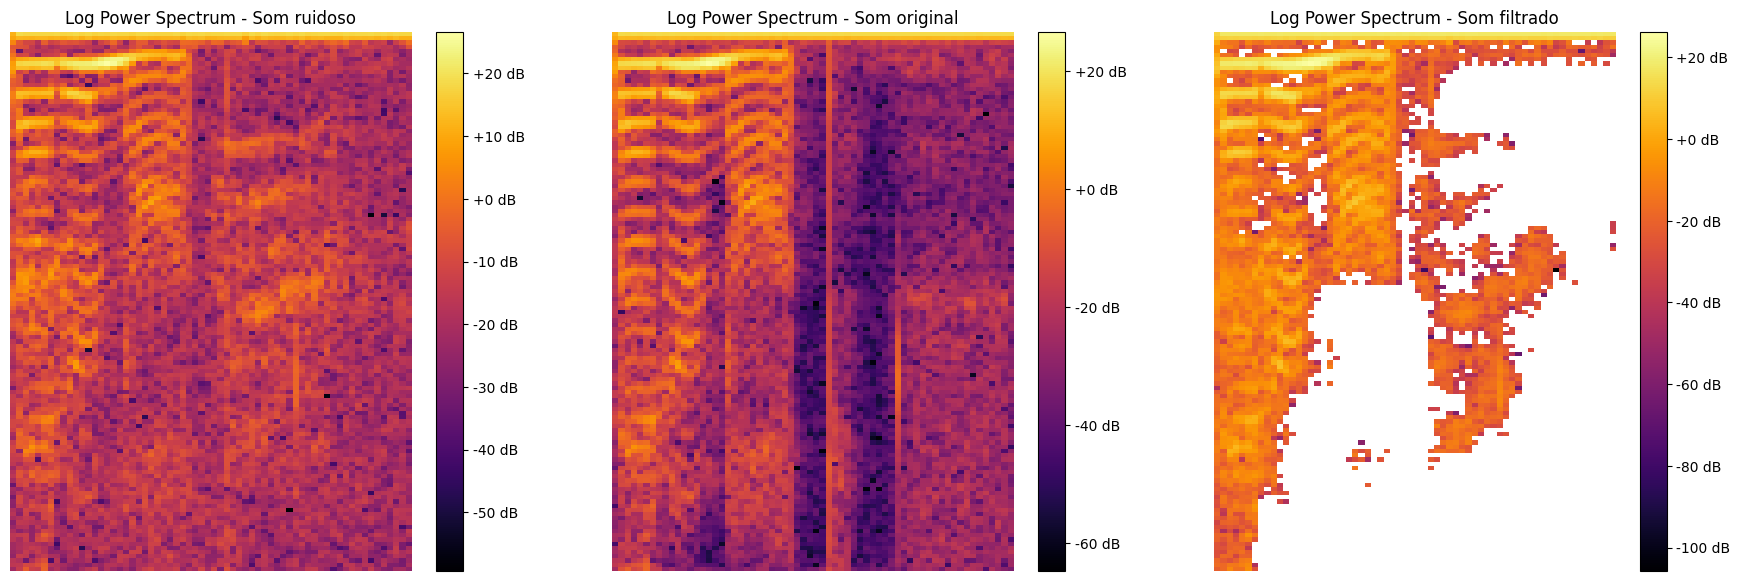

Epoch 5:  68%|██████▊   | 300/438 [14:20<06:35,  2.86s/batch, loss=0.0323]

(1, 128, 64)
(1, 128, 64)


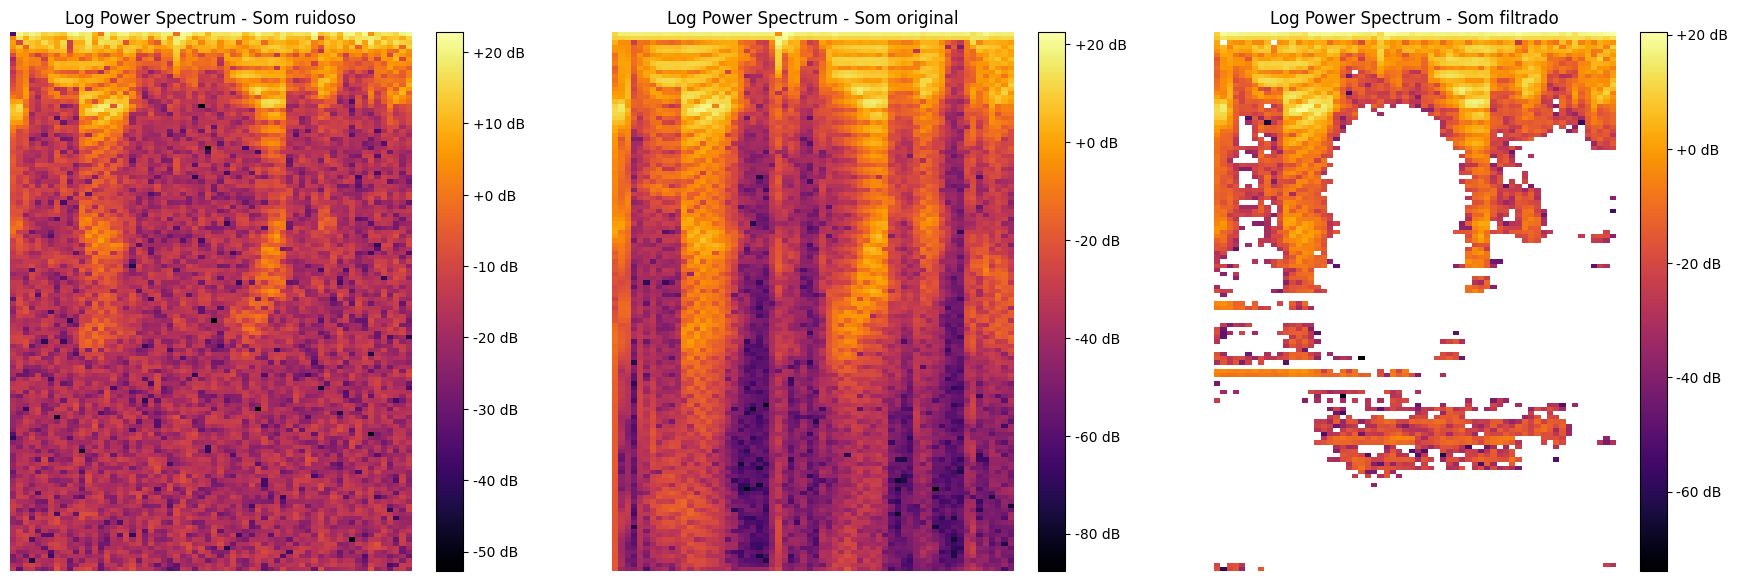

Epoch 5:  91%|█████████▏| 400/438 [19:07<01:48,  2.86s/batch, loss=0.0408]

(1, 128, 64)
(1, 128, 64)


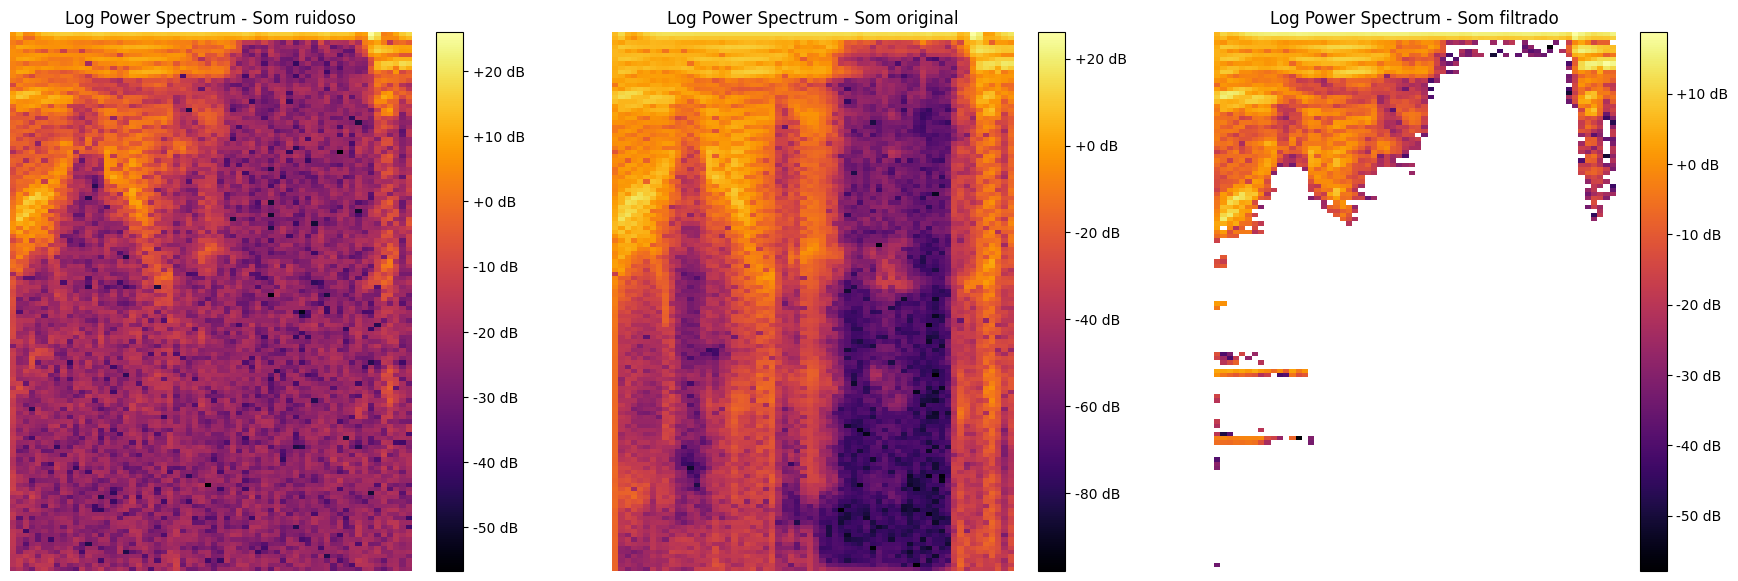

Epoch 5: 100%|█████████▉| 437/438 [20:56<00:02,  2.88s/batch, loss=0.0512]


Running Epoch: 5


Epoch 6:   0%|          | 0/438 [00:00<?, ?batch/s]

(1, 128, 64)
(1, 128, 64)


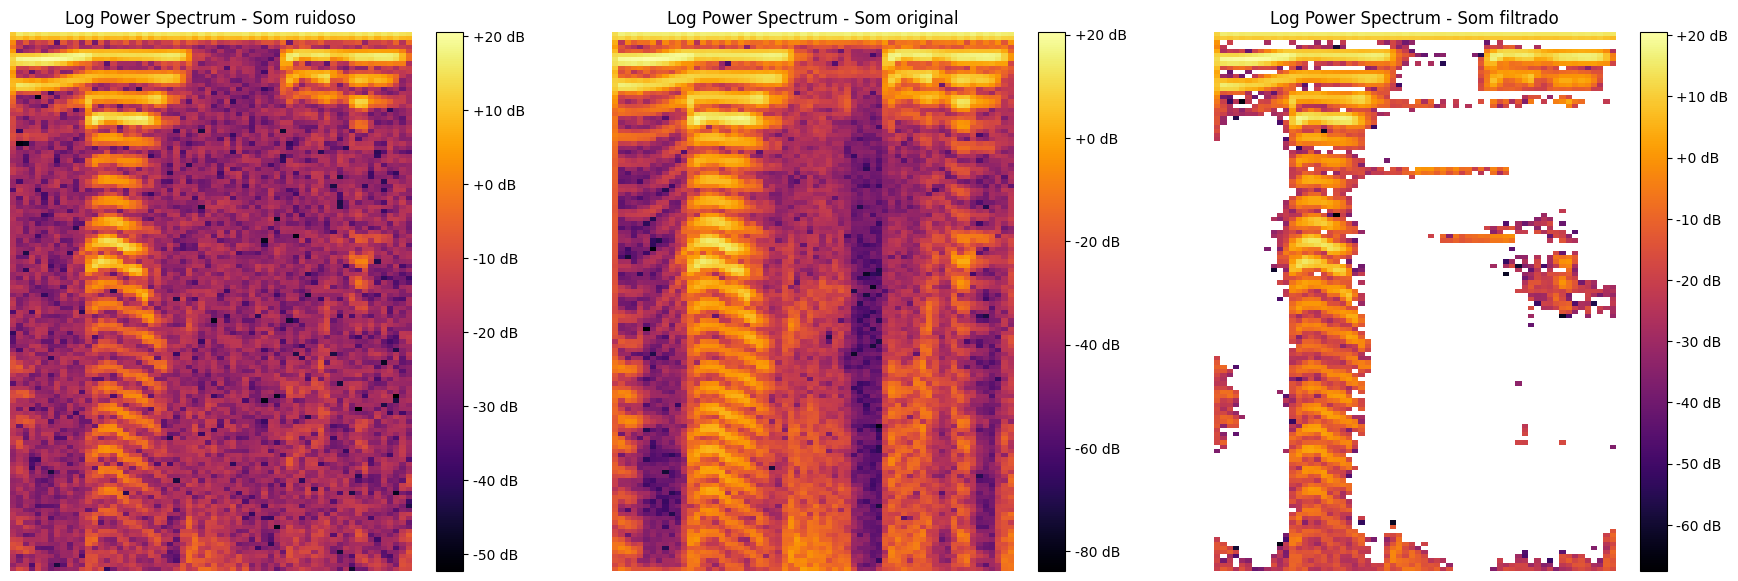

Epoch 6:  23%|██▎       | 100/438 [04:46<16:08,  2.87s/batch, loss=0.0244]

(1, 128, 64)
(1, 128, 64)


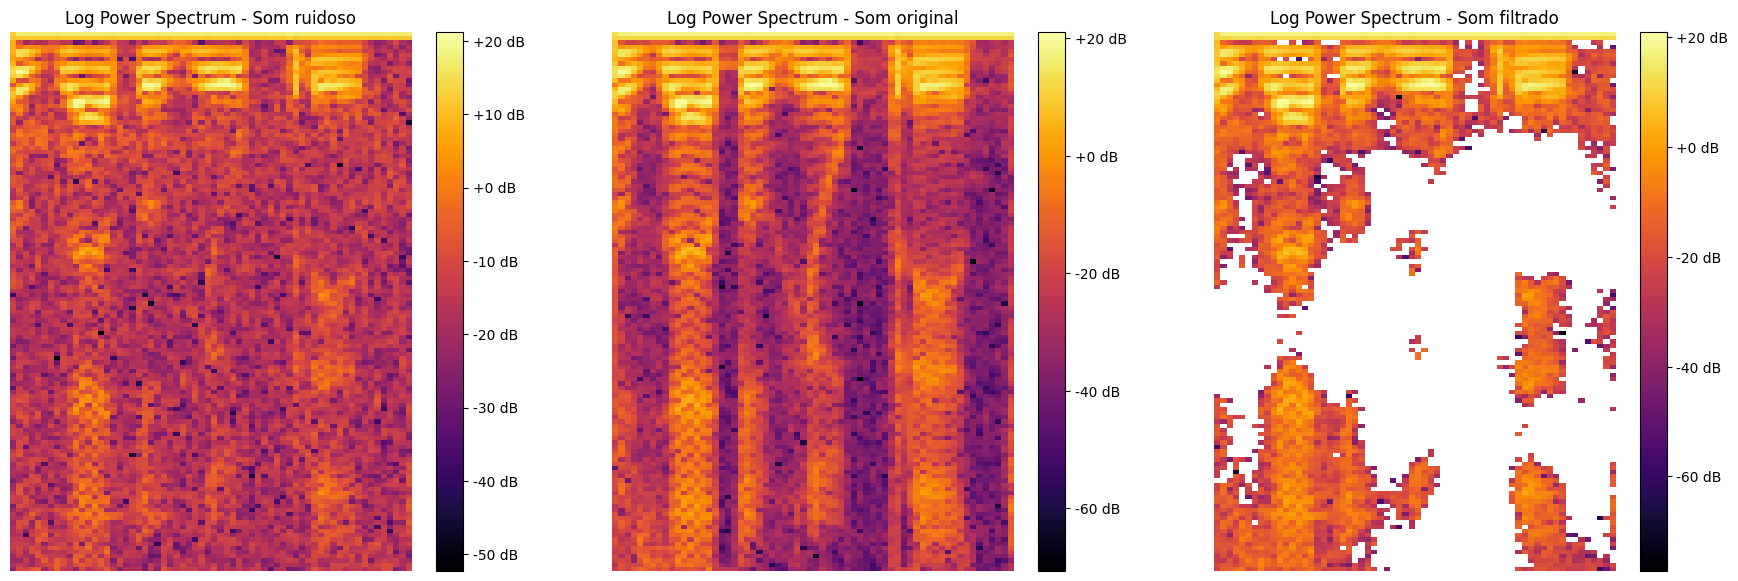

Epoch 6:  46%|████▌     | 200/438 [09:33<11:21,  2.86s/batch, loss=0.0325]

(1, 128, 64)
(1, 128, 64)


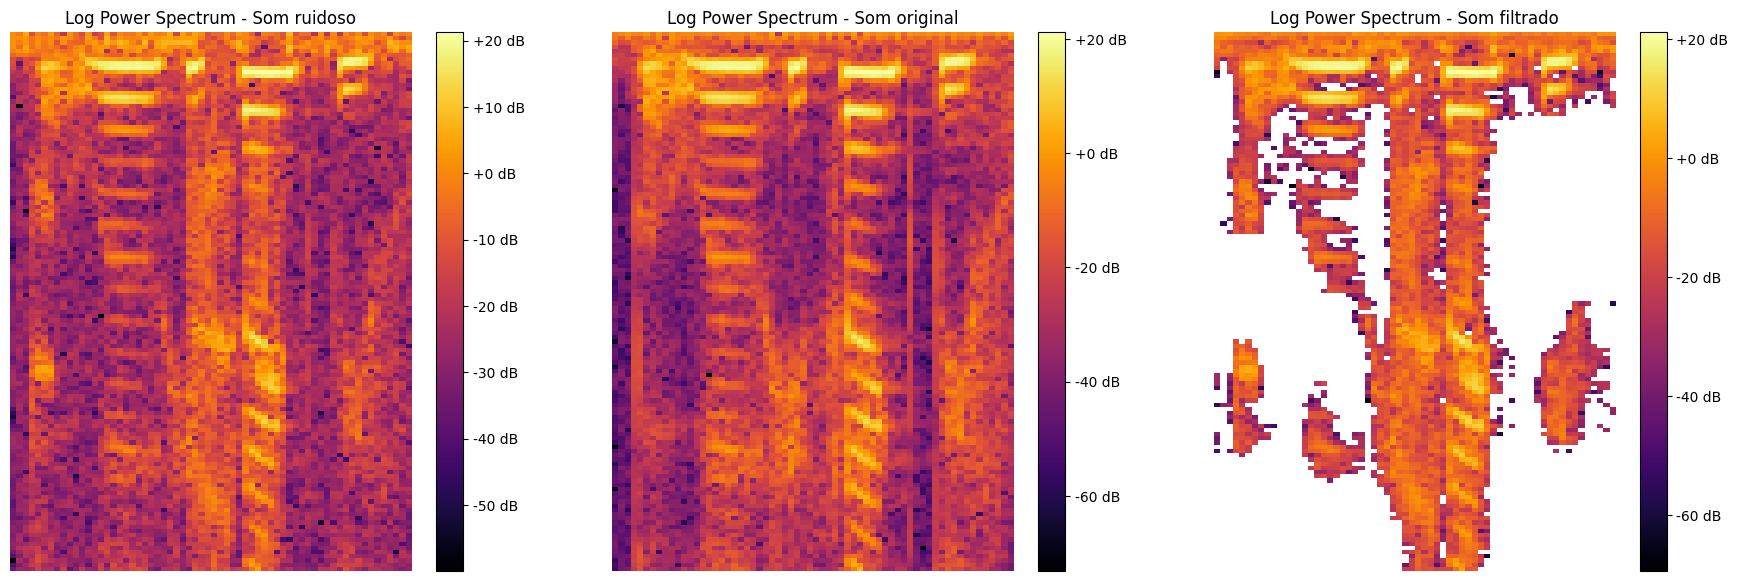

Epoch 6:  68%|██████▊   | 300/438 [14:20<06:35,  2.86s/batch, loss=0.0229]

(1, 128, 64)
(1, 128, 64)


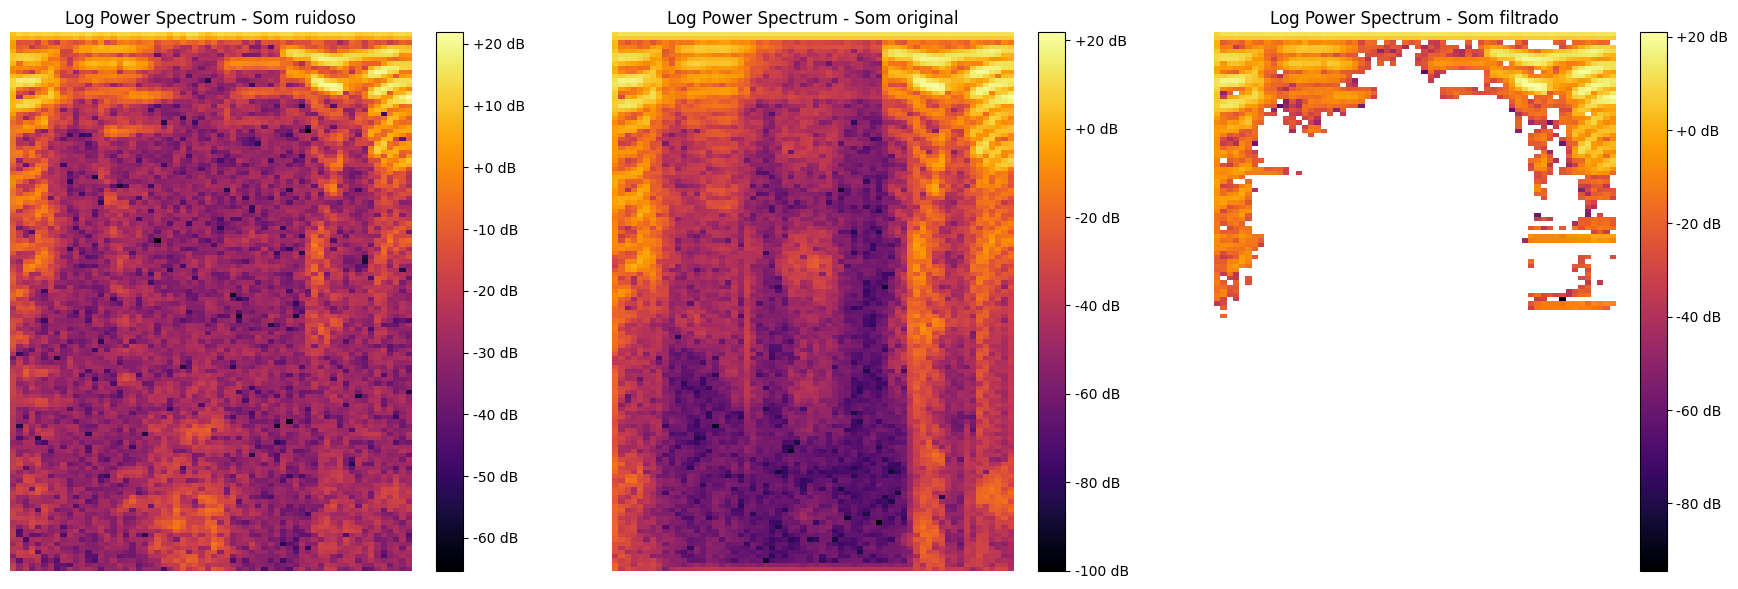

Epoch 6:  91%|█████████▏| 400/438 [19:07<01:48,  2.87s/batch, loss=0.0354]

(1, 128, 64)
(1, 128, 64)


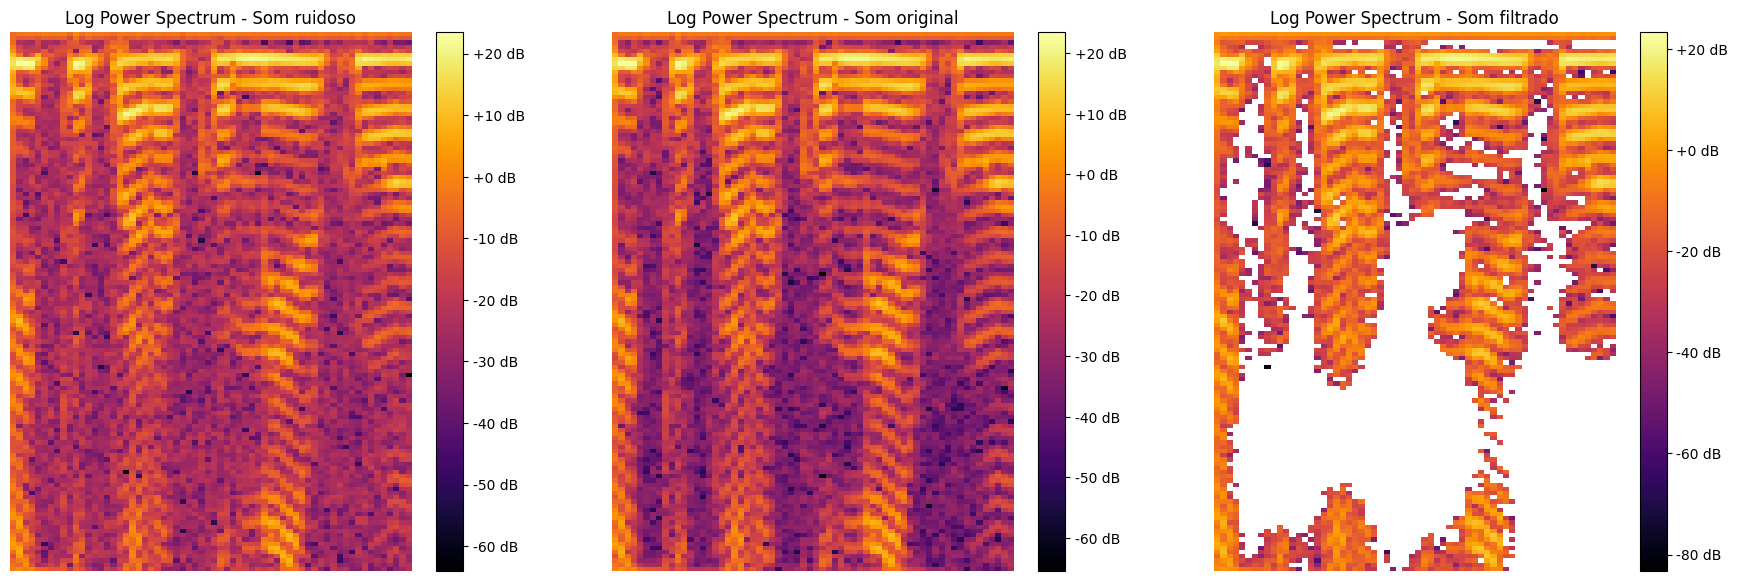

Epoch 6: 100%|█████████▉| 437/438 [20:56<00:02,  2.88s/batch, loss=0.0254]


Running Epoch: 6


Epoch 7:   0%|          | 0/438 [00:00<?, ?batch/s]

(1, 128, 64)
(1, 128, 64)


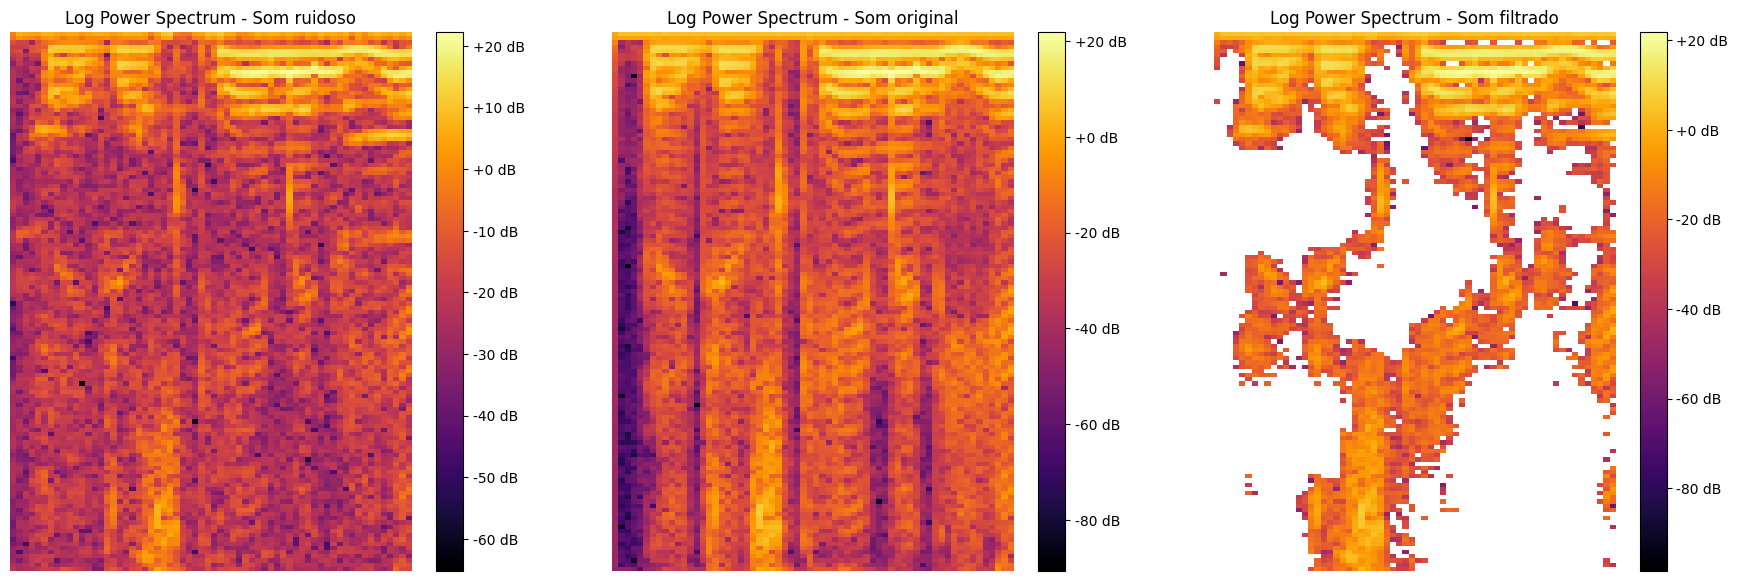

Epoch 7:  23%|██▎       | 100/438 [04:46<16:08,  2.87s/batch, loss=0.0293]

(1, 128, 64)
(1, 128, 64)


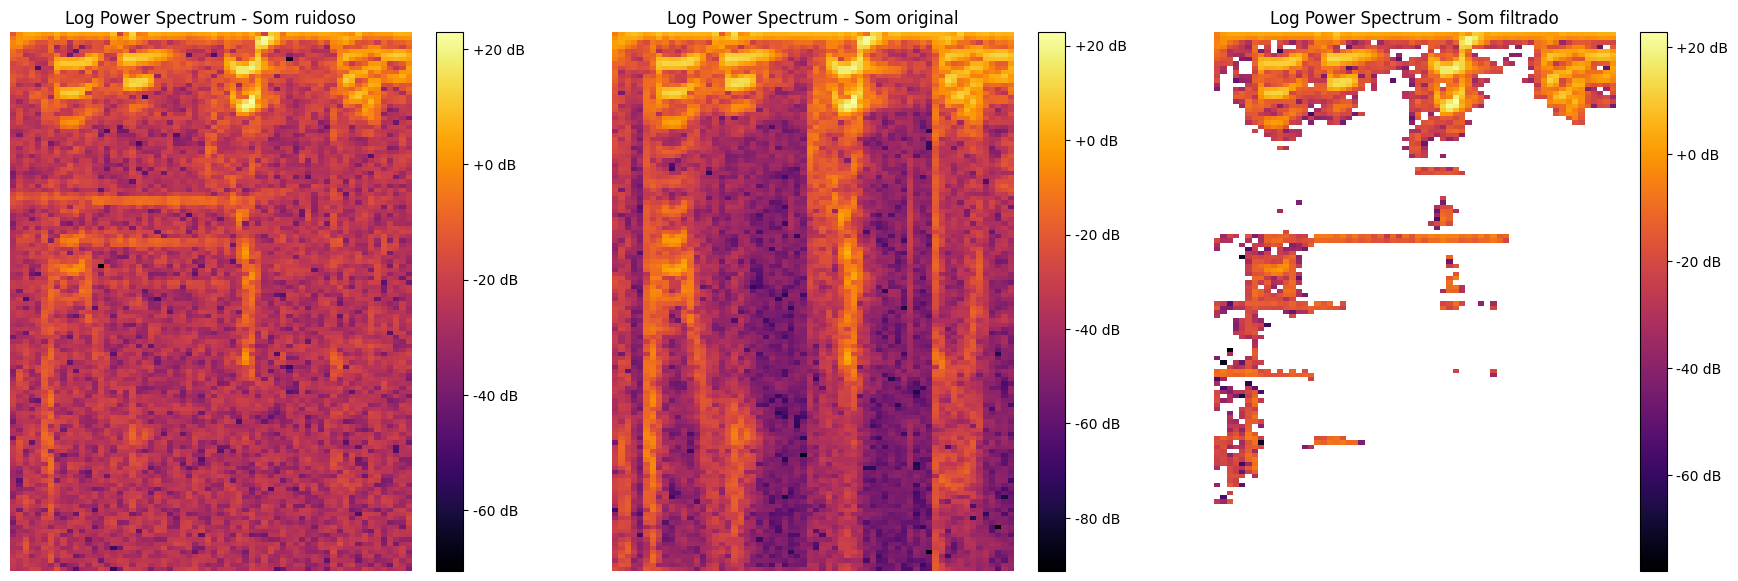

Epoch 7:  46%|████▌     | 200/438 [09:33<11:21,  2.86s/batch, loss=0.0249]

(1, 128, 64)
(1, 128, 64)


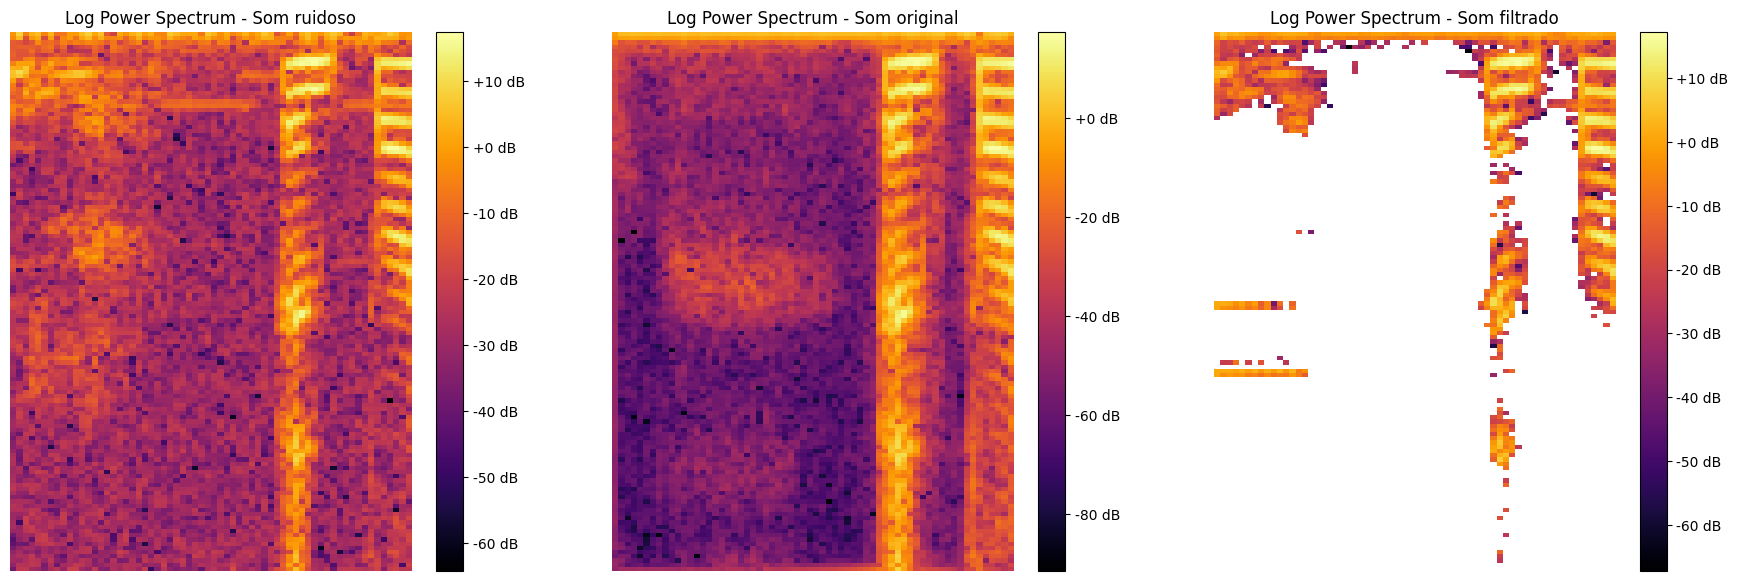

Epoch 7:  68%|██████▊   | 300/438 [14:20<06:35,  2.87s/batch, loss=0.0242]

(1, 128, 64)
(1, 128, 64)


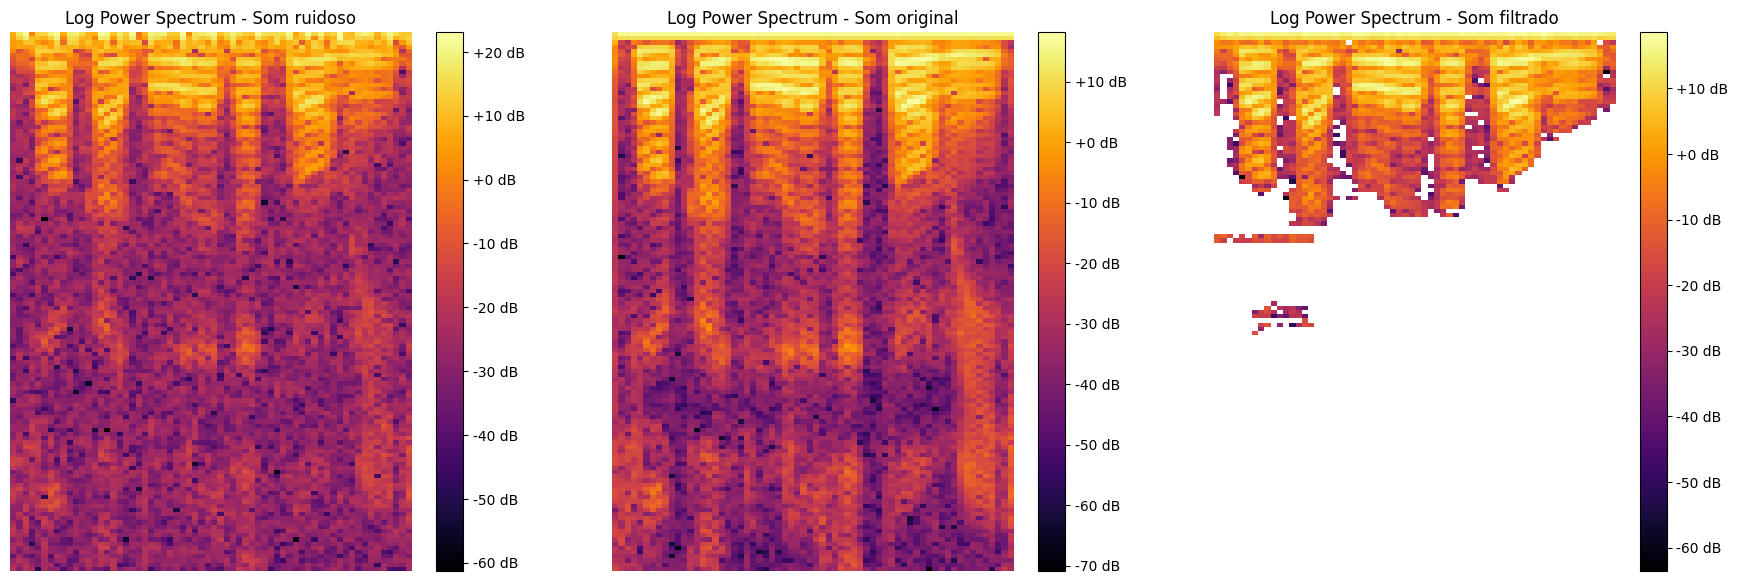

Epoch 7:  91%|█████████▏| 400/438 [19:07<01:48,  2.86s/batch, loss=0.025] 

(1, 128, 64)
(1, 128, 64)


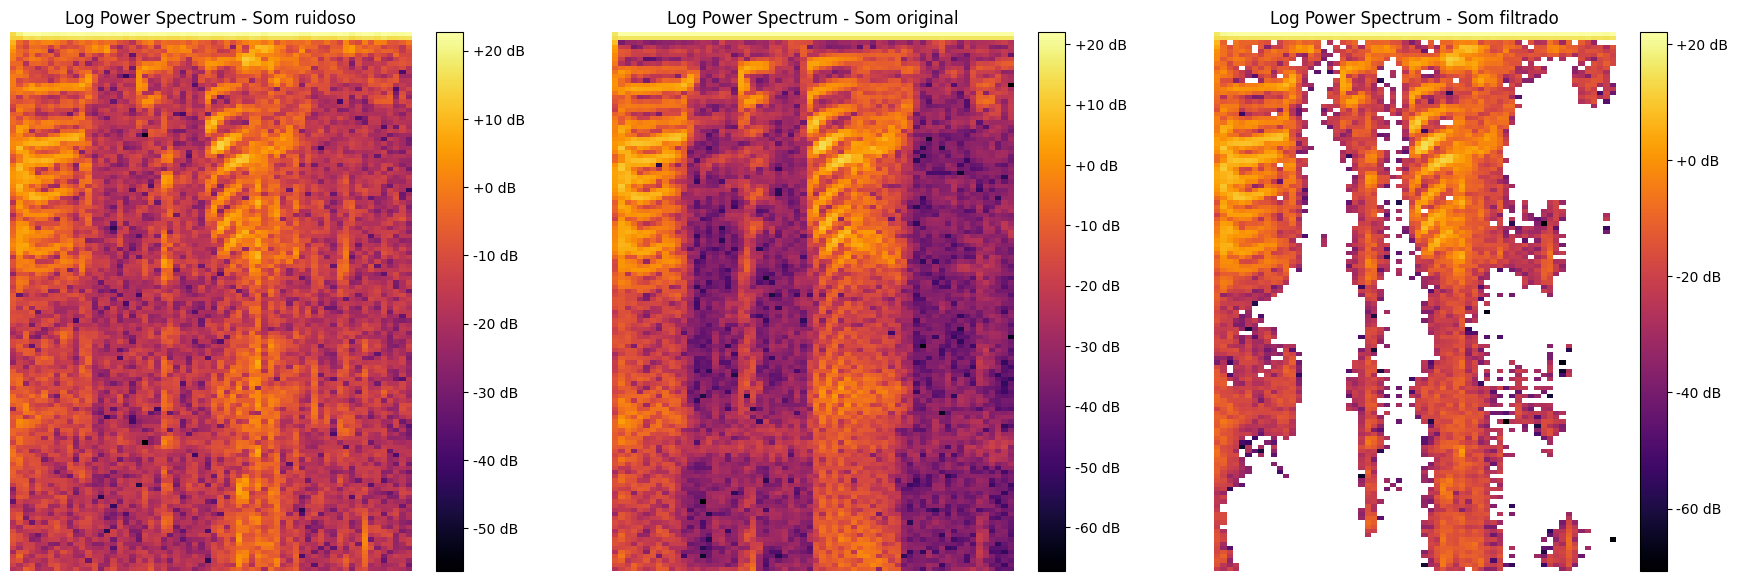

Epoch 7: 100%|█████████▉| 437/438 [20:56<00:02,  2.88s/batch, loss=0.0189]


Running Epoch: 7


Epoch 8:   0%|          | 0/438 [00:00<?, ?batch/s]

(1, 128, 64)
(1, 128, 64)


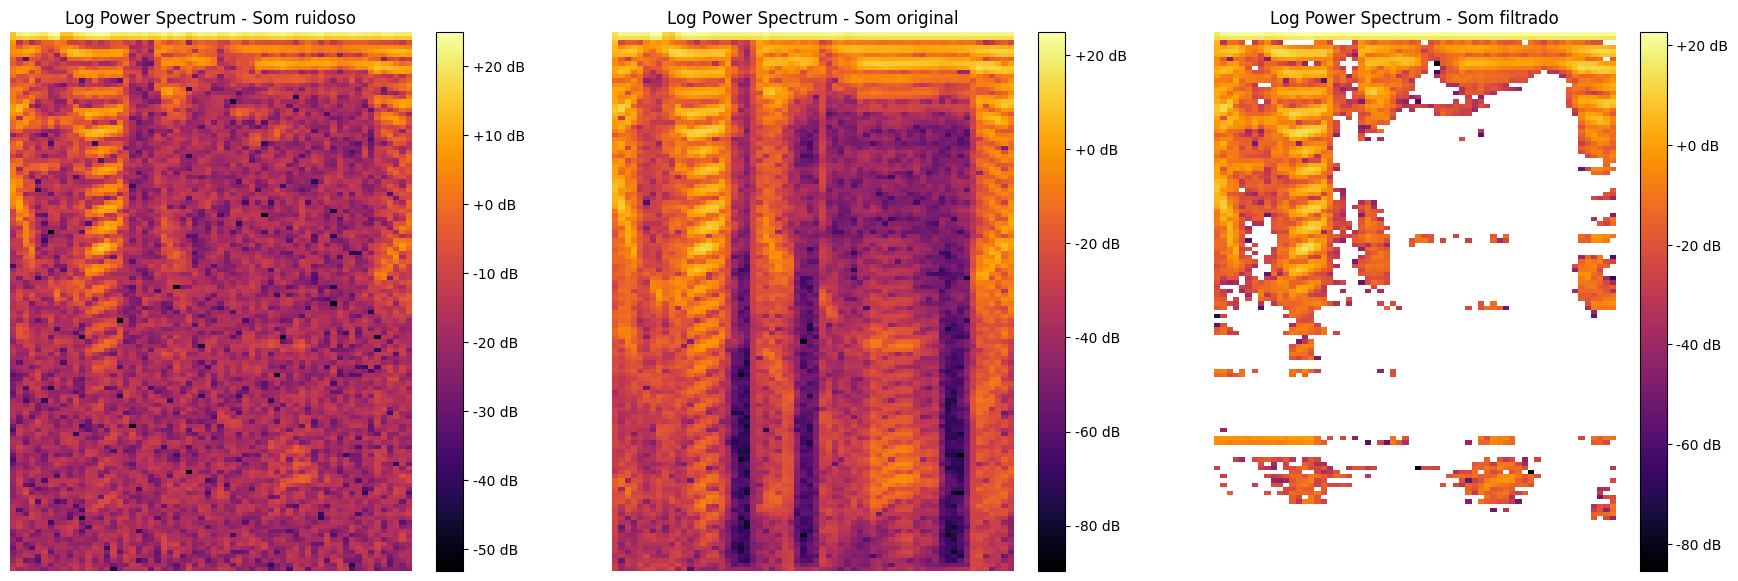

Epoch 8:  23%|██▎       | 100/438 [04:46<16:06,  2.86s/batch, loss=0.0289]

(1, 128, 64)
(1, 128, 64)


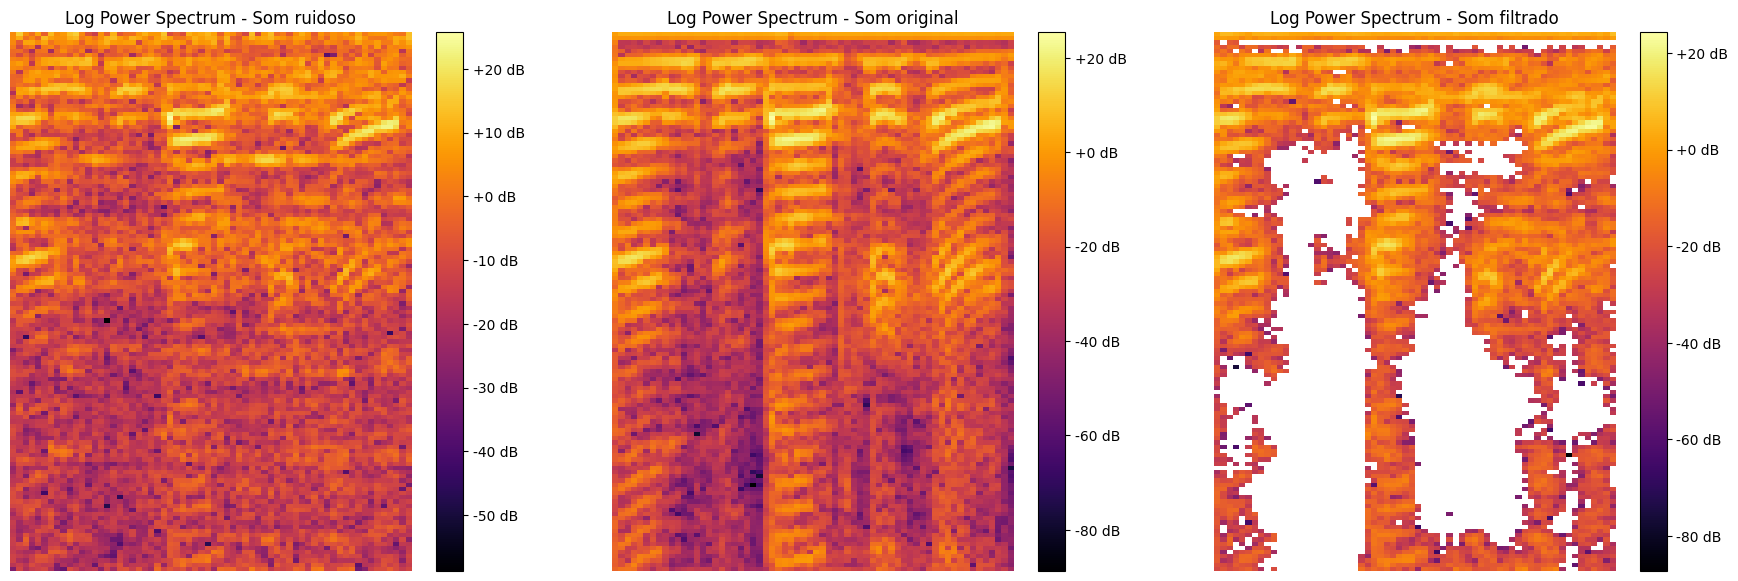

Epoch 8:  46%|████▌     | 200/438 [09:33<11:22,  2.87s/batch, loss=0.0274]

(1, 128, 64)
(1, 128, 64)


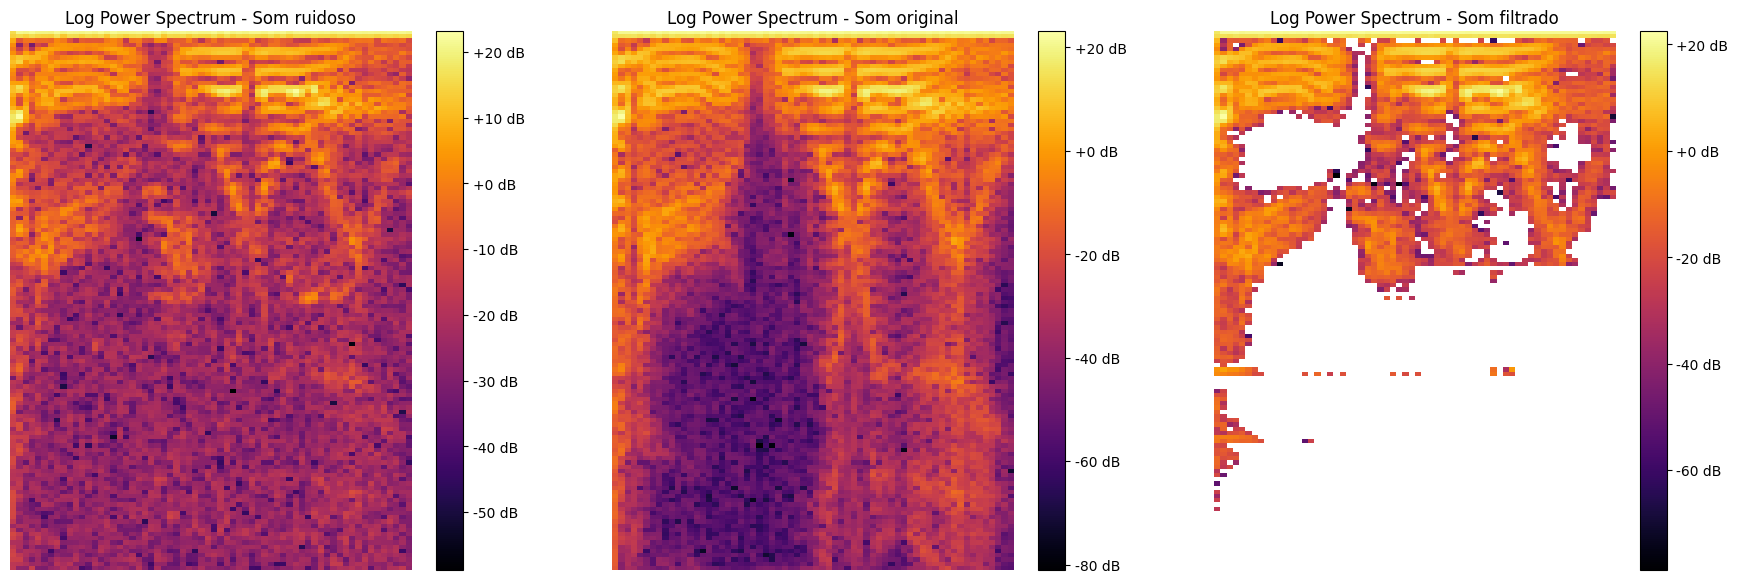

Epoch 8:  68%|██████▊   | 300/438 [14:20<06:35,  2.86s/batch, loss=0.0282]

(1, 128, 64)
(1, 128, 64)


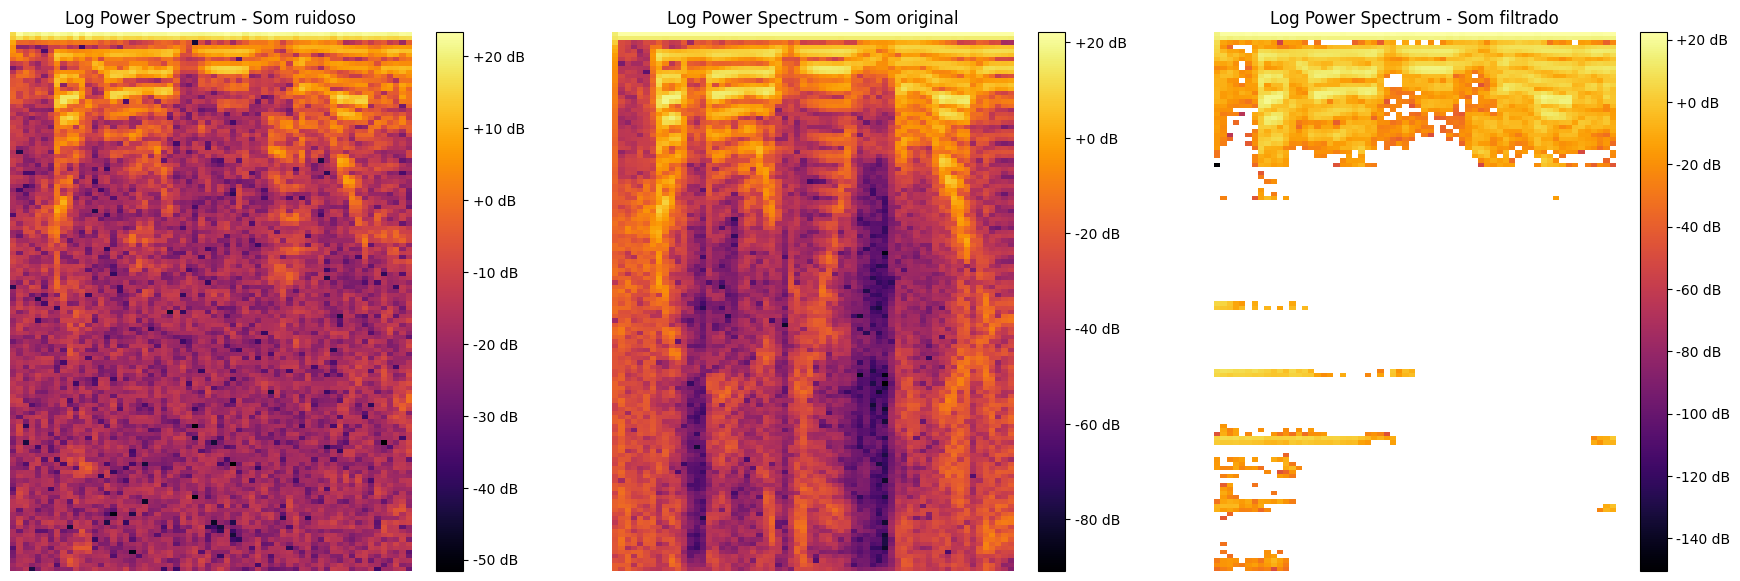

Epoch 8:  91%|█████████▏| 400/438 [19:07<01:48,  2.87s/batch, loss=0.0284]

(1, 128, 64)
(1, 128, 64)


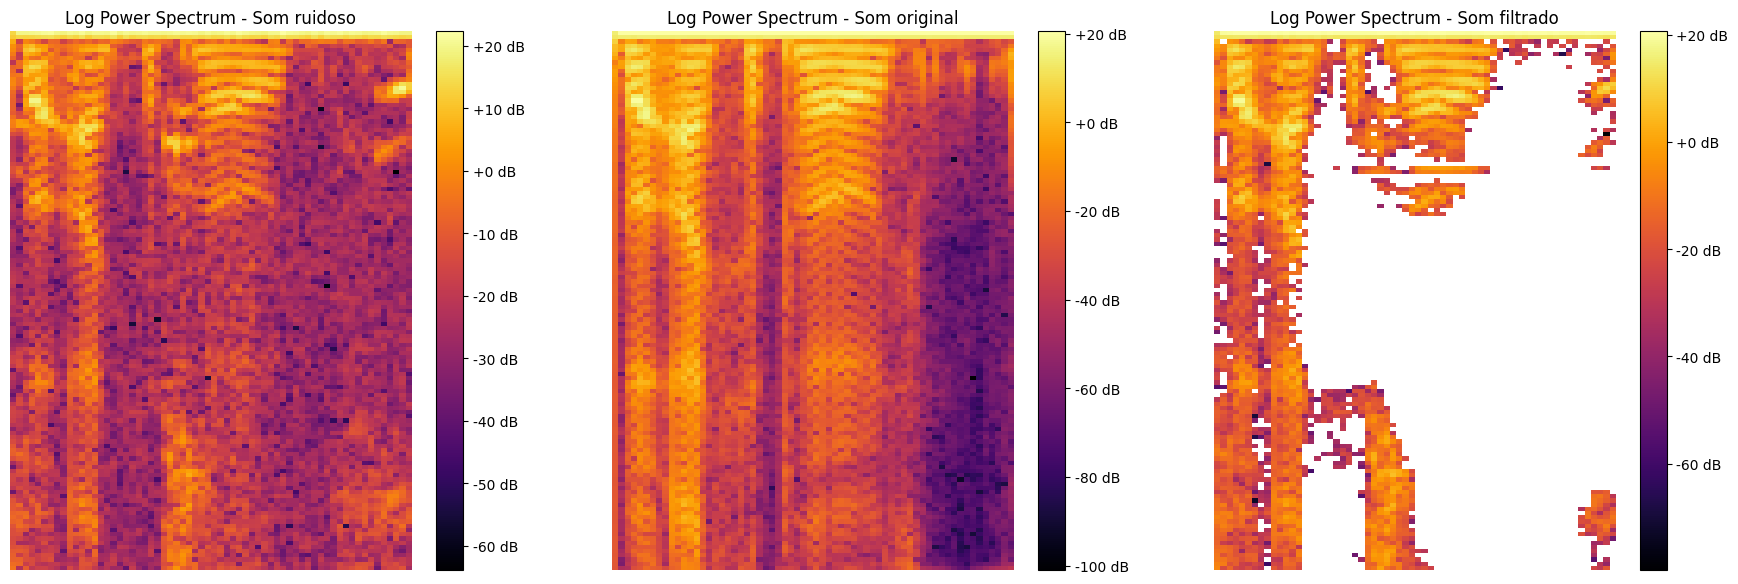

Epoch 8: 100%|█████████▉| 437/438 [20:56<00:02,  2.88s/batch, loss=0.0255]


Running Epoch: 8


Epoch 9:   0%|          | 0/438 [00:00<?, ?batch/s]

(1, 128, 64)
(1, 128, 64)


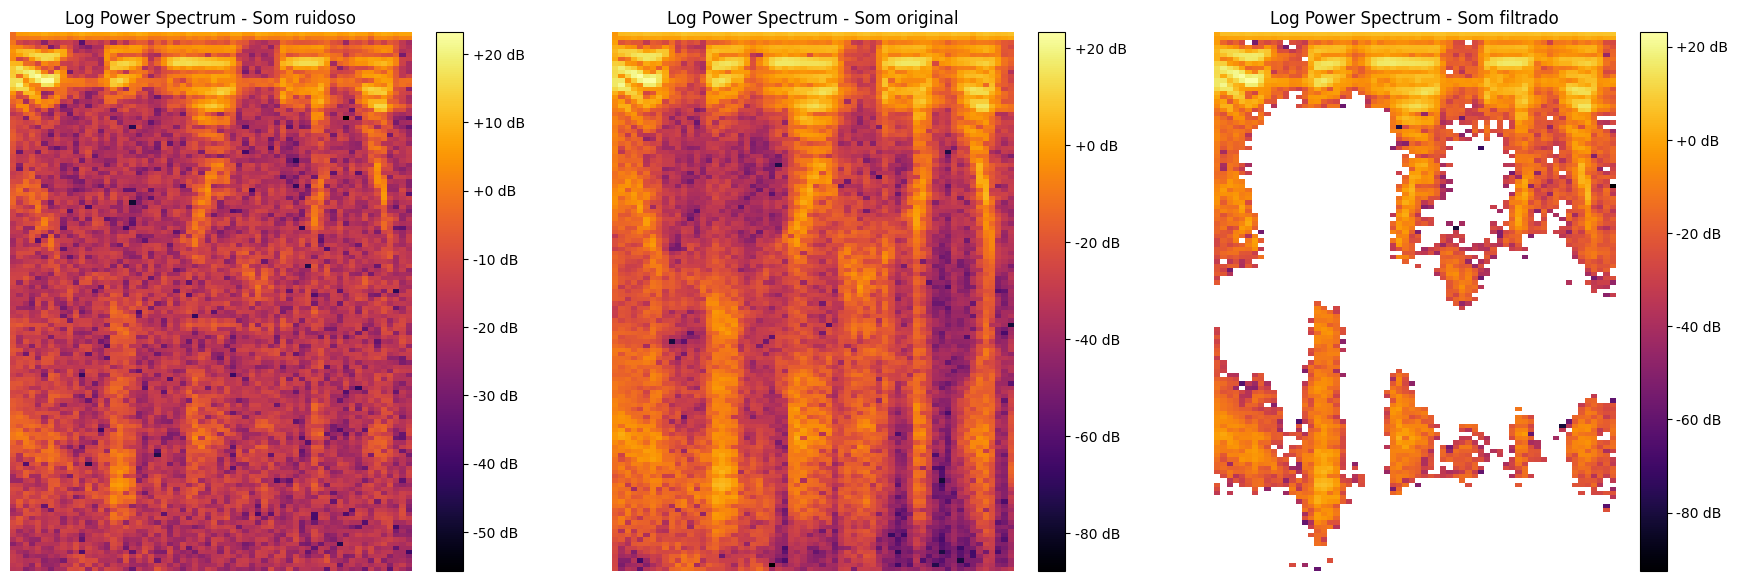

Epoch 9:  23%|██▎       | 100/438 [04:46<16:09,  2.87s/batch, loss=0.0245]

(1, 128, 64)
(1, 128, 64)


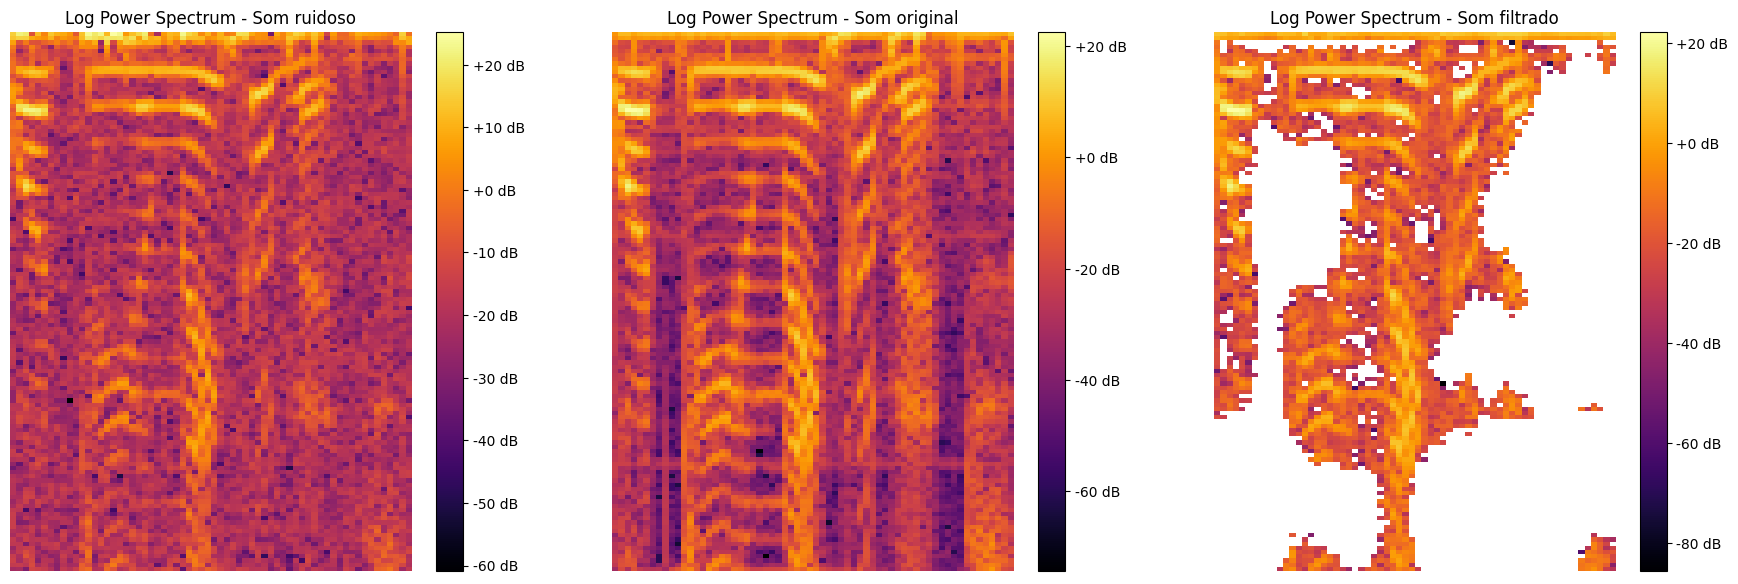

Epoch 9:  46%|████▌     | 200/438 [09:33<11:22,  2.87s/batch, loss=0.0323]

(1, 128, 64)
(1, 128, 64)


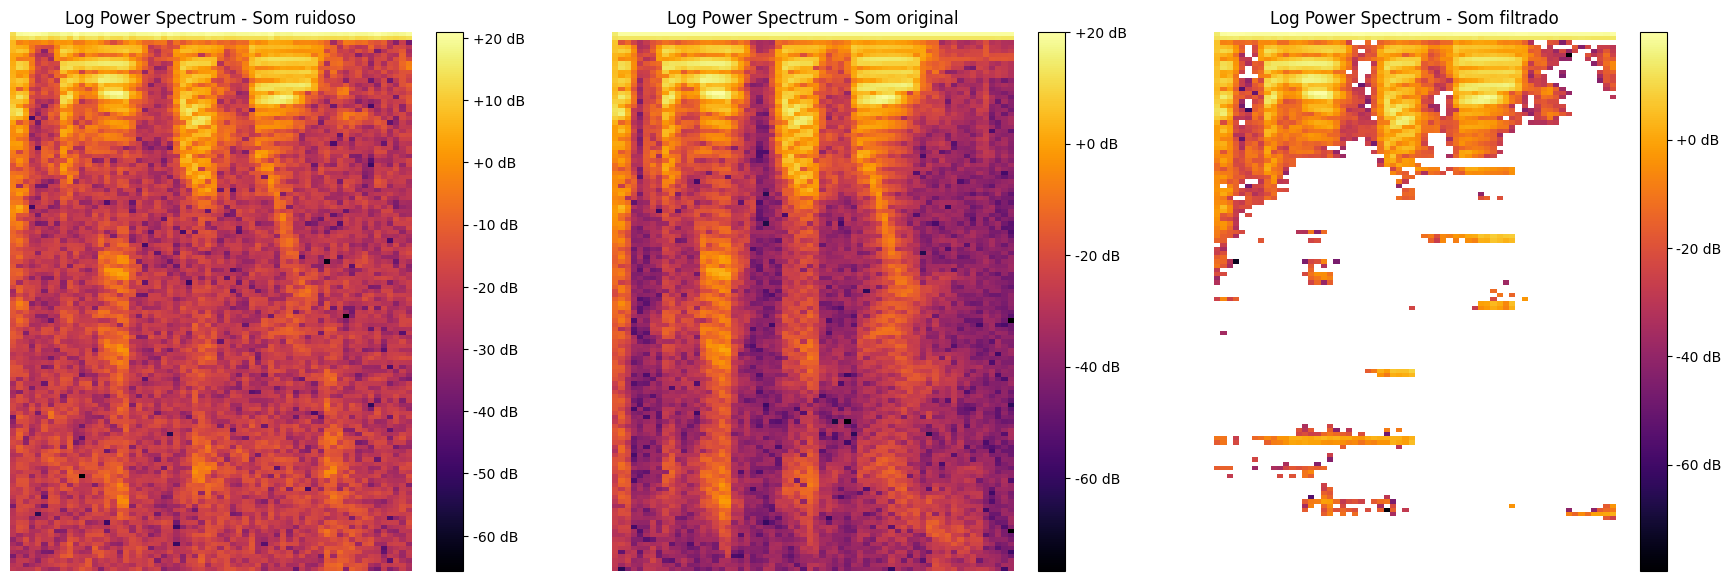

Epoch 9:  68%|██████▊   | 300/438 [14:20<06:35,  2.87s/batch, loss=0.0239]

(1, 128, 64)
(1, 128, 64)


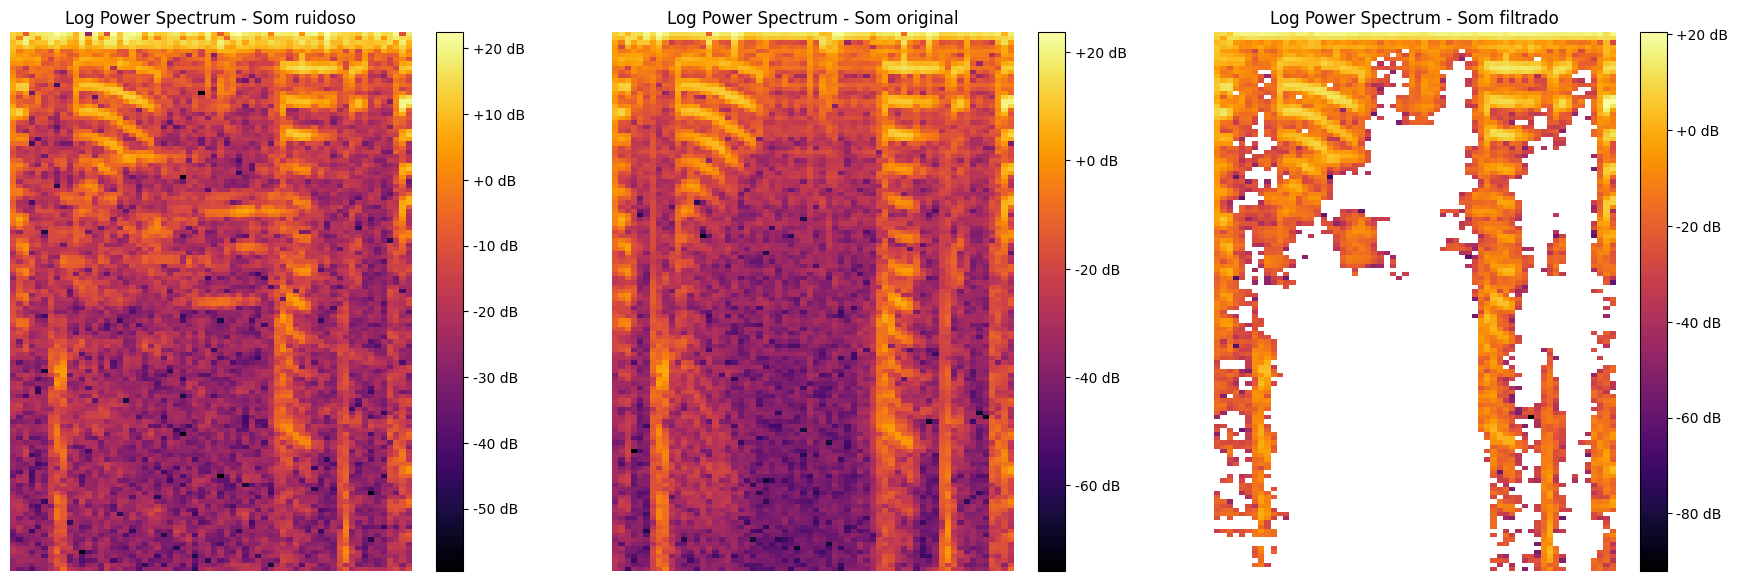

Epoch 9:  91%|█████████▏| 400/438 [19:07<01:48,  2.87s/batch, loss=0.0229]

(1, 128, 64)
(1, 128, 64)


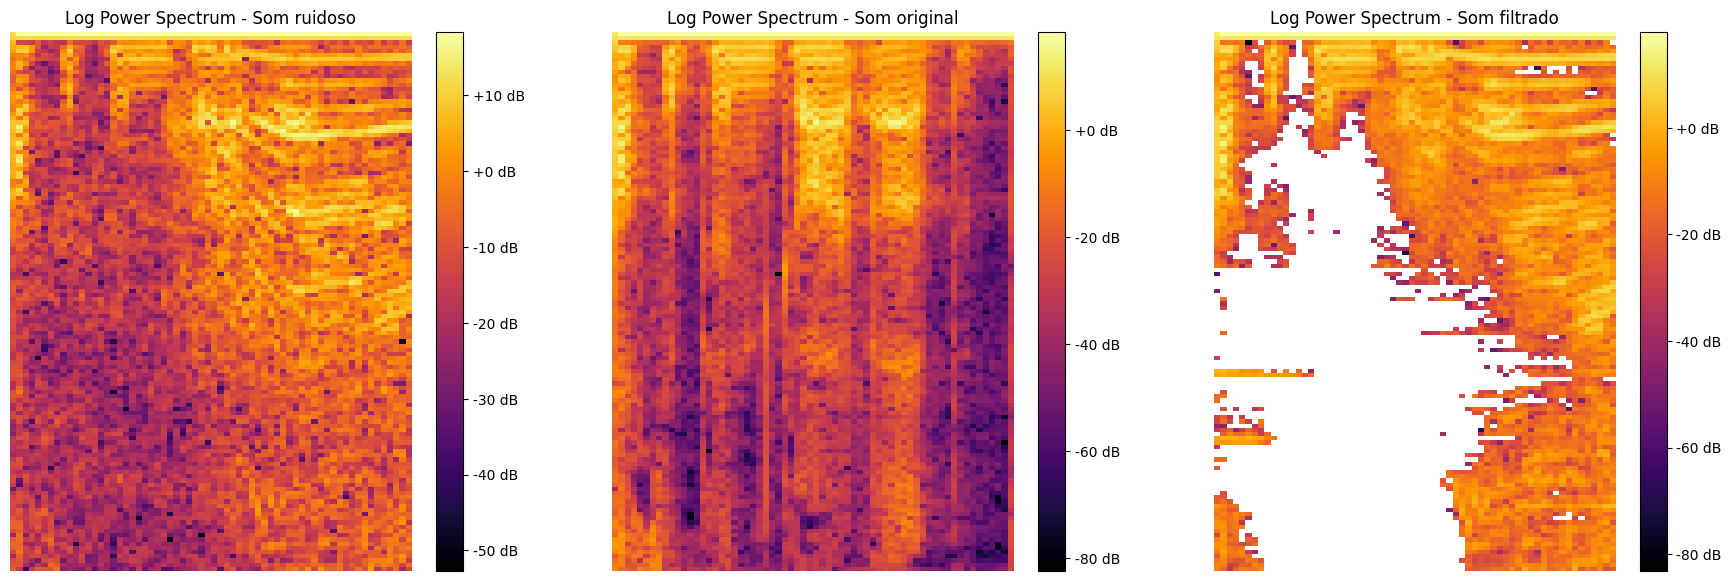

Epoch 9: 100%|█████████▉| 437/438 [20:57<00:02,  2.88s/batch, loss=0.0286]


Running Epoch: 9


Epoch 10:   0%|          | 0/438 [00:00<?, ?batch/s]

(1, 128, 64)
(1, 128, 64)


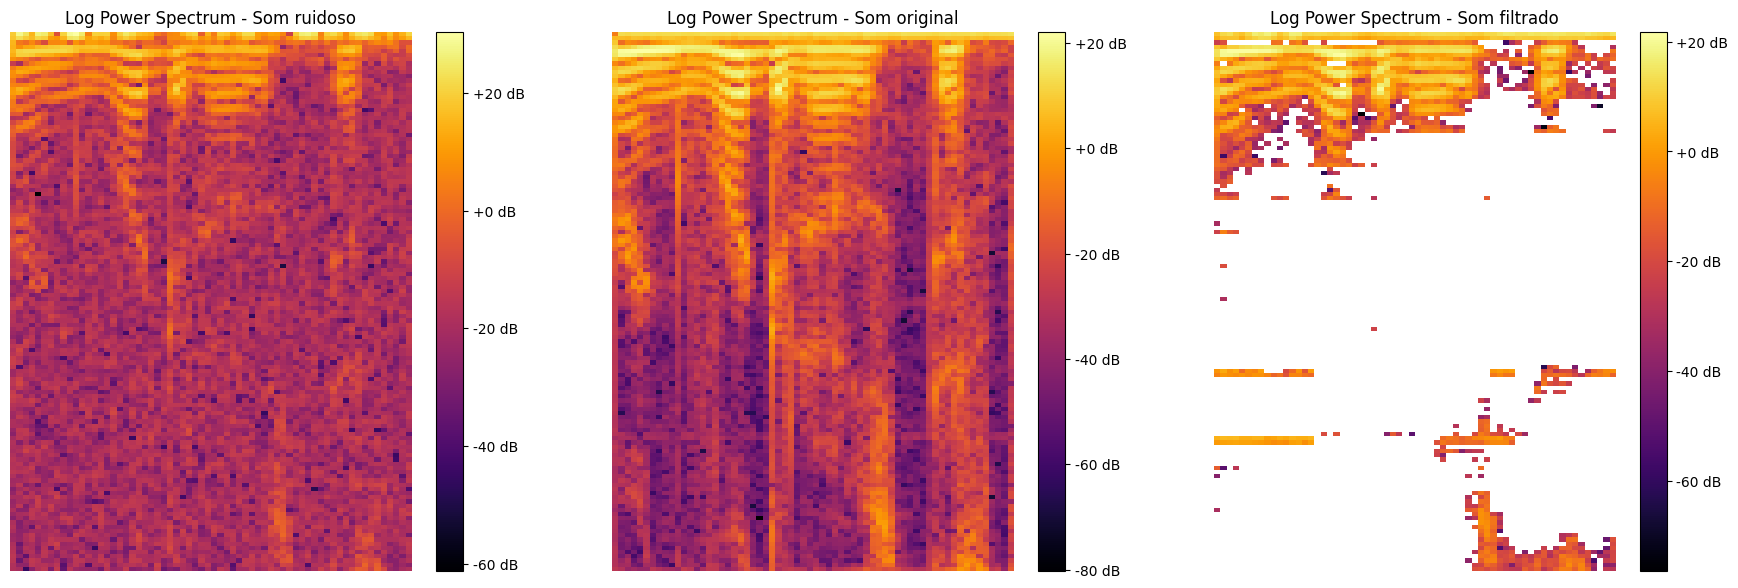

Epoch 10:  10%|█         | 44/438 [02:13<19:55,  3.03s/batch, loss=0.0359]


KeyboardInterrupt: 

In [18]:
# Suponha que você conheça o número de batches por epoch
num_batches_per_epoch = len(sound_base_train.clean_sounds) // batch_size

print("Start training Attention Res U-Net...")
model.train()

for epoch in range(epochs):
    print(f'Running Epoch: {epoch}')
    overall_loss = 0

    # Envolva o iterador do loop interno com tqdm para criar uma barra de progresso
    progress_bar = tqdm(data_generator_train.generate_sample_completo(batch_size=batch_size, include_clean=True, only_return_mudule=True), 
                        desc=f"Epoch {epoch + 1}", unit="batch", total=num_batches_per_epoch)
    
    for batch_idx, (x, y) in enumerate(progress_bar):
        x = torch.from_numpy(x).permute(0, 3, 1, 2).to(DEVICE)
        y = torch.from_numpy(y).permute(0, 3, 1, 2).to(DEVICE)

        optimizer.zero_grad()

        x_hat = model(x)
        loss = mse_loss(x_hat, y)
                
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_step == 0: 
            # Gere e exiba imagens
            generate_images(model, x, y)
        
        # Atualize a barra de progresso com o valor atual de loss
        progress_bar.set_postfix(loss=loss.item())
        
        # Pare o loop após processar o número desejado de batches
        if batch_idx >= num_batches_per_epoch - 1:
            break
    
print("Finish!!")

In [19]:
# Salvar o estado do modelo e do otimizador
torch.save(model.state_dict(), 'model_weights.pth')
torch.save(optimizer.state_dict(), 'optimizer_state.pth')

# Opcional: Salvar o modelo completo
torch.save(model, 'complete_model.pth')